## **Title: Strategic Optimization of Supply Chain Sustainability through Sector-Based Greenhouse Gas Emission Analysis**
#R Rashmi


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# **Scope and objectives**

| Question no.    | Research Questions     | Methods       |
|--------------|--------------|----------------|
| 1      | Is there a statistically significant difference in mean SEF between Manufacturing (NAICS 31-33) and Services (NAICS 51-56) commodities?          | An Independent Samples T-Test (or Mann-Whitney U test if data is non-normal) will test the null hypothesis (H₀: μ_Mfg = μ_Svc)   |
| 2      | To what extent does the Margin Emission Factor (MEF) correlate with the base Supply Chain Emission Factor (SEF)?       | Pearson Correlation Coefficient and scatter plot visualization  |
| 3     | Can a commodity's total CO2e intensity be accurately predicted using the intensities of specific non-CO2 gases (CH₄, N₂O)?          | A Random Forest Regression model will be trained with normalized CH₄ and N₂O intensities as features and the Total EF as the target  |
| 4      | Can U.S. commodities be segmented into distinct "Carbon Risk  clusters" based on their combined SEF and MEF profiles?          | K-Means Clustering on Z-score standardized SEF and MEF values  |

#**Data Loading, preparation and Exploration.**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving SupplyChain.xlsx to SupplyChain.xlsx


In [3]:
file_path = list(uploaded.keys())[0]

In [4]:
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
sheet_names

['GHG', 'CO2']

In [5]:
df_GHG = pd.read_excel(file_path, sheet_name='GHG')

print("Data shape:", df_GHG.shape)
print("\nFirst 5 rows:")
print(df_GHG.head())
print("\nColumn names:")
print(df_GHG.columns.tolist())
print("\nData types:")
print(df_GHG.dtypes)
print("\nMissing values per column:")
print(df_GHG.isnull().sum())

Data shape: (18288, 8)

First 5 rows:
   2017 NAICS Code 2017 NAICS Title                   GHG  \
0           111110  Soybean Farming                HFC-23   
1           111110  Soybean Farming        Carbon dioxide   
2           111110  Soybean Farming             HFC-236fa   
3           111110  Soybean Farming  Carbon tetrafluoride   
4           111110  Soybean Farming                HFC-32   

                           Unit  \
0  kg/2022 USD, purchaser price   
1  kg/2022 USD, purchaser price   
2  kg/2022 USD, purchaser price   
3  kg/2022 USD, purchaser price   
4  kg/2022 USD, purchaser price   

   Supply Chain Emission Factors without Margins  \
0                                   3.230000e-09   
1                                   1.340000e-01   
2                                   1.440000e-10   
3                                   5.130000e-09   
4                                   3.000000e-08   

   Margins of Supply Chain Emission Factors  \
0                       

In [6]:
df_CO2 = pd.read_excel(file_path, sheet_name='CO2')

print("Data shape:", df_CO2.shape)
print("\nFirst 5 rows:")
print(df_CO2.head())
print("\nColumn names:")
print(df_CO2.columns.tolist())
print("\nData types:")
print(df_CO2.dtypes)
print("\nMissing values per column:")
print(df_CO2.isnull().sum())

Data shape: (1016, 8)

First 5 rows:
   2017 NAICS Code                  2017 NAICS Title       GHG  \
0           111110                   Soybean Farming  All GHGs   
1           111120  Oilseed (except Soybean) Farming  All GHGs   
2           111130          Dry Pea and Bean Farming  All GHGs   
3           111140                     Wheat Farming  All GHGs   
4           111150                      Corn Farming  All GHGs   

                                Unit  \
0  kg CO2e/2022 USD, purchaser price   
1  kg CO2e/2022 USD, purchaser price   
2  kg CO2e/2022 USD, purchaser price   
3  kg CO2e/2022 USD, purchaser price   
4  kg CO2e/2022 USD, purchaser price   

   Supply Chain Emission Factors without Margins  \
0                                          0.488   
1                                          0.488   
2                                          0.809   
3                                          0.809   
4                                          0.809   

   Margins o

In [7]:
num_cols = [
    'Supply Chain Emission Factors without Margins',
    'Margins of Supply Chain Emission Factors',
    'Supply Chain Emission Factors with Margins'
]
for col in num_cols:
    df_GHG[col] = pd.to_numeric(df_GHG[col], errors='coerce')

In [8]:
# Extract sector from NAICS code
df_GHG['NAICS_Sector'] = df_GHG['2017 NAICS Code'].astype(str).str[:2]
sector_names = {
    '11': 'Agriculture, Forestry, Fishing',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '45': 'Retail Trade',
    '48': 'Transportation',
    '49': 'Transportation',
    '51': 'Information',
    '52': 'Finance',
    '53': 'Real Estate',
    '54': 'Professional Services',
    '55': 'Management',
    '56': 'Administrative',
    '61': 'Educational',
    '62': 'Health Care',
    '71': 'Arts',
    '72': 'Accommodation',
    '81': 'Other Services',
    '92': 'Public Administration'
}
df_GHG['Sector'] = df_GHG['NAICS_Sector'].map(sector_names).fillna('Other')

# Define GHG categories
def categorize_ghg(ghg):
    ghg_low = ghg.lower()
    if 'carbon dioxide' in ghg_low or 'co2' in ghg_low:
        return 'CO₂'
    elif 'methane' in ghg_low:
        return 'CH₄'
    elif 'nitrous' in ghg_low:
        return 'N₂O'
    elif 'hfc' in ghg_low:
        return 'HFCs'
    elif 'pfc' in ghg_low or 'perfluoro' in ghg_low:
        return 'PFCs'
    elif 'sulfur hexafluoride' in ghg_low:
        return 'SF₆'
    elif 'nitrogen trifluoride' in ghg_low:
        return 'NF₃'
    else:
        return 'Other'

df_GHG['GHG_Category'] = df_GHG['GHG'].apply(categorize_ghg)

In [9]:
print("Unit counts:\n", df_GHG['Unit'].value_counts())

Unit counts:
 Unit
kg/2022 USD, purchaser price         17272
kg CO2e/2022 USD, purchaser price     1016
Name: count, dtype: int64


In [10]:
print(df_GHG[num_cols].describe())

       Supply Chain Emission Factors without Margins  \
count                                   1.828800e+04   
mean                                    1.022439e-02   
std                                     6.376527e-02   
min                                     1.970000e-11   
25%                                     1.330000e-09   
50%                                     1.420000e-08   
75%                                     3.387500e-07   
max                                     3.790000e+00   

       Margins of Supply Chain Emission Factors  \
count                              1.828800e+04   
mean                               8.167654e-04   
std                                5.772884e-03   
min                                0.000000e+00   
25%                                0.000000e+00   
50%                                0.000000e+00   
75%                                1.610000e-09   
max                                1.090000e-01   

       Supply Chain Emission Factor

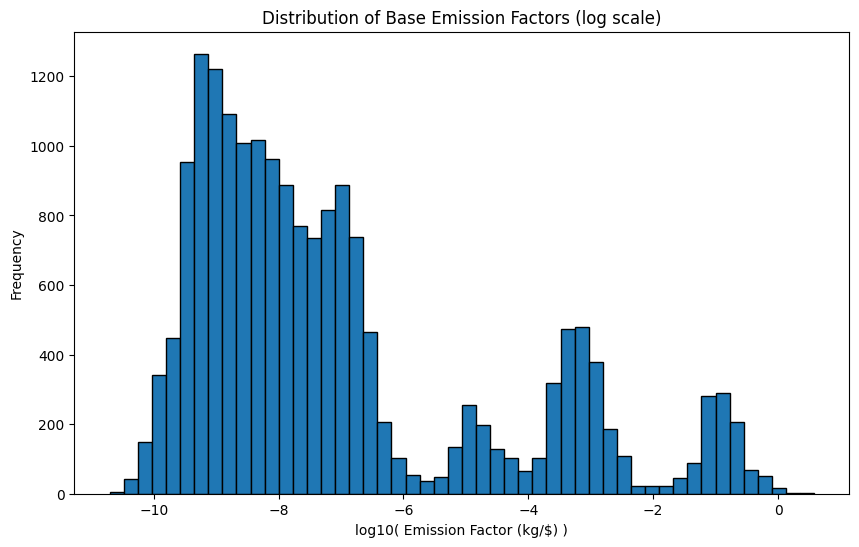

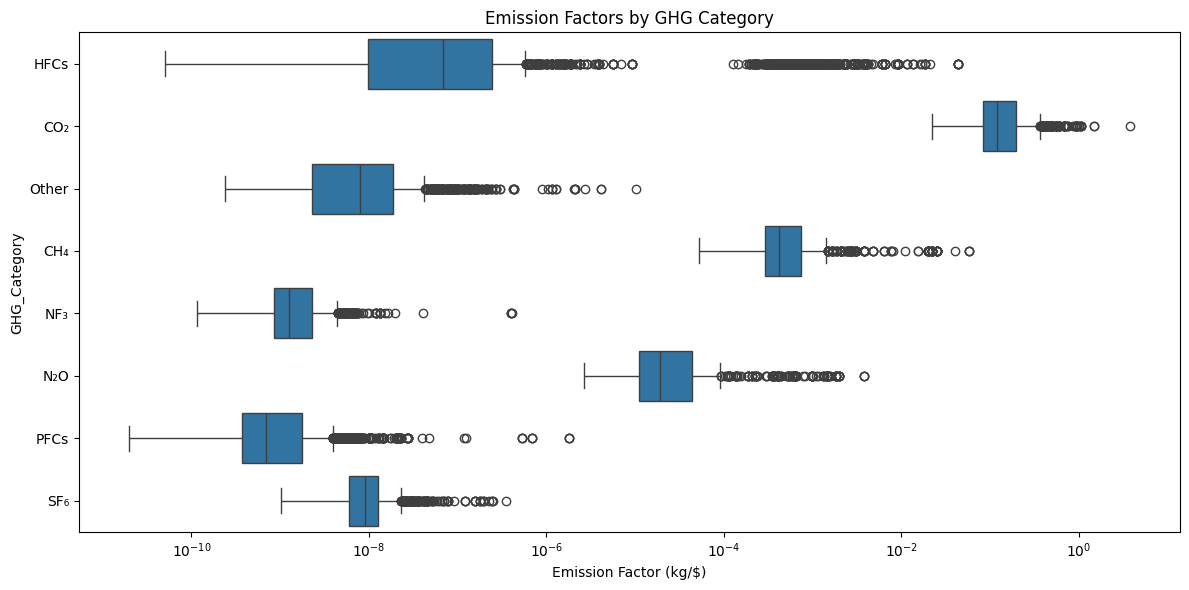

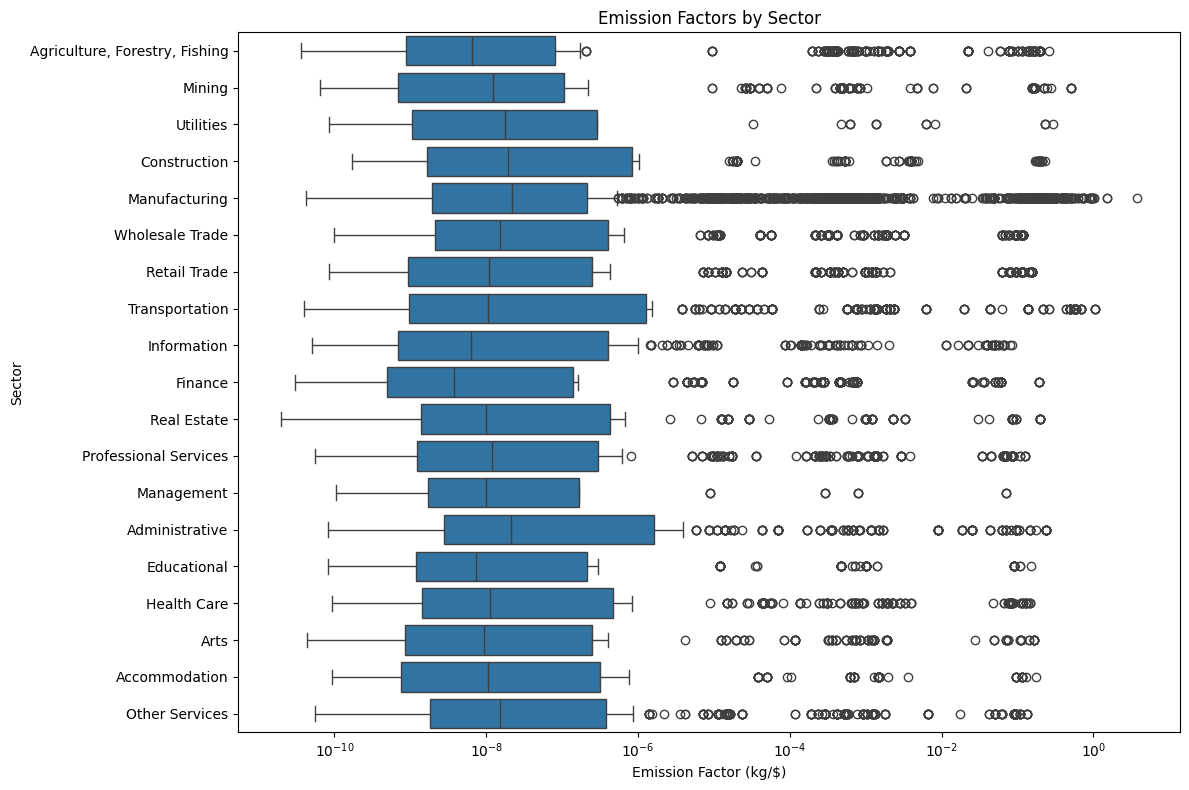

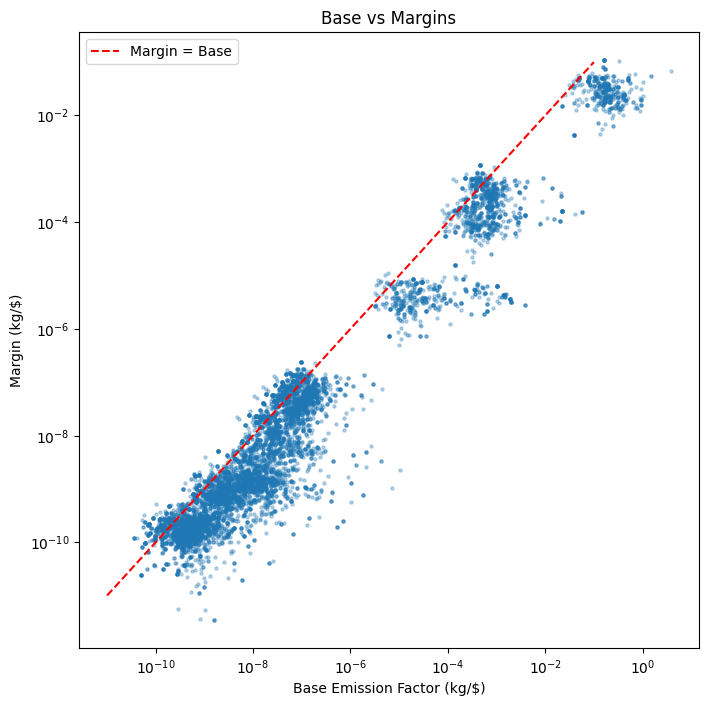

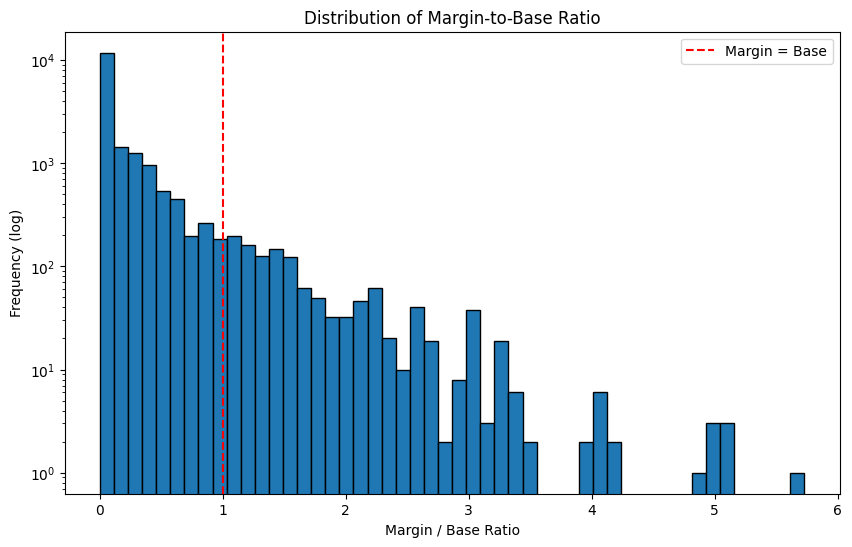

Number of outliers: 4200 (22.97%)
                    2017 NAICS Title                         GHG  \
1                    Soybean Farming              Carbon dioxide   
6                    Soybean Farming  HFCs and PFCs, unspecified   
8                    Soybean Farming                     Methane   
12                   Soybean Farming               Nitrous oxide   
18  Oilseed (except Soybean) Farming              Carbon dioxide   
24  Oilseed (except Soybean) Farming               Nitrous oxide   
31  Oilseed (except Soybean) Farming  HFCs and PFCs, unspecified   
33  Oilseed (except Soybean) Farming                     Methane   
41          Dry Pea and Bean Farming              Carbon dioxide   
42          Dry Pea and Bean Farming  HFCs and PFCs, unspecified   

    Supply Chain Emission Factors without Margins  
1                                        0.134000  
6                                        0.000358  
8                                        0.000331  
12       

In [11]:
plt.figure(figsize=(10,6))
plt.hist(np.log10(df_GHG['Supply Chain Emission Factors without Margins'] + 1e-15), bins=50, edgecolor='black')
plt.xlabel('log10( Emission Factor (kg/$) )')
plt.ylabel('Frequency')
plt.title('Distribution of Base Emission Factors (log scale)')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df_GHG, x='Supply Chain Emission Factors without Margins', y='GHG_Category', orient='h')
plt.xscale('log')
plt.xlabel('Emission Factor (kg/$)')
plt.title('Emission Factors by GHG Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(data=df_GHG, x='Supply Chain Emission Factors without Margins', y='Sector', orient='h')
plt.xscale('log')
plt.xlabel('Emission Factor (kg/$)')
plt.title('Emission Factors by Sector')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(df_GHG['Supply Chain Emission Factors without Margins'],
            df_GHG['Margins of Supply Chain Emission Factors'],
            alpha=0.3, s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Base Emission Factor (kg/$)')
plt.ylabel('Margin (kg/$)')
plt.title('Base vs Margins')
plt.plot([1e-11, 1e-1], [1e-11, 1e-1], 'r--', label='Margin = Base')
plt.legend()
plt.show()

df_GHG['Margin_Ratio'] = df_GHG['Margins of Supply Chain Emission Factors'] / df_GHG['Supply Chain Emission Factors without Margins']
plt.figure(figsize=(10,6))
plt.hist(df_GHG['Margin_Ratio'], bins=50, edgecolor='black', log=True)
plt.xlabel('Margin / Base Ratio')
plt.ylabel('Frequency (log)')
plt.title('Distribution of Margin-to-Base Ratio')
plt.axvline(1, color='red', linestyle='--', label='Margin = Base')
plt.legend()
plt.show()

Q1 = df_GHG['Supply Chain Emission Factors without Margins'].quantile(0.25)
Q3 = df_GHG['Supply Chain Emission Factors without Margins'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df_GHG[(df_GHG['Supply Chain Emission Factors without Margins'] < lower) |
              (df_GHG['Supply Chain Emission Factors without Margins'] > upper)]
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(df_GHG)*100:.2f}%)")
print(outliers[['2017 NAICS Title', 'GHG', 'Supply Chain Emission Factors without Margins']].head(10))

In [12]:
sector_avg = df_GHG.groupby('Sector')['Supply Chain Emission Factors without Margins'].mean().sort_values(ascending=False)
print(sector_avg)

Sector
Transportation                    0.024392
Utilities                         0.014273
Manufacturing                     0.014251
Mining                            0.013513
Construction                      0.011100
Agriculture, Forestry, Fishing    0.008675
Administrative                    0.007792
Real Estate                       0.006845
Accommodation                     0.006398
Retail Trade                      0.005988
Arts                              0.005924
Wholesale Trade                   0.005562
Health Care                       0.005518
Educational                       0.005365
Other Services                    0.004969
Professional Services             0.004226
Management                        0.004044
Finance                           0.003763
Information                       0.002812
Name: Supply Chain Emission Factors without Margins, dtype: float64


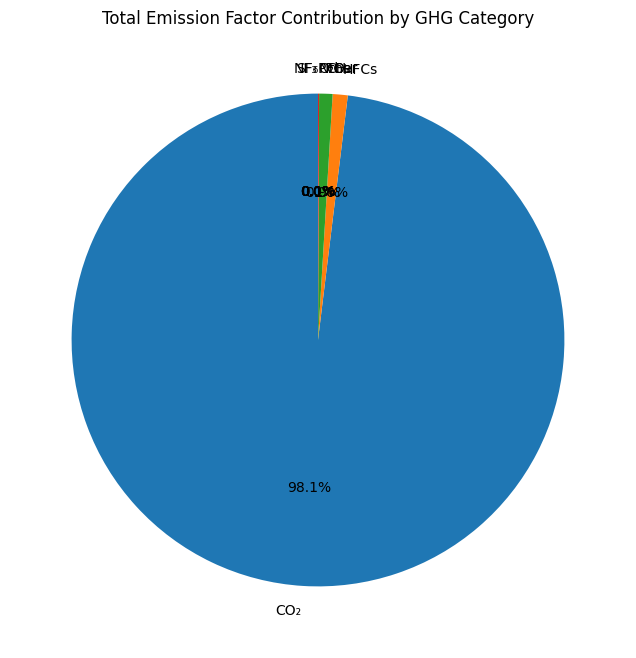

GHG_Category                         CH₄       CO₂      HFCs           NF₃  \
Sector                                                                       
Accommodation                   0.000758  0.112693  0.000237  7.753333e-10   
Administrative                  0.006653  0.128445  0.000733  3.026455e-09   
Agriculture, Forestry, Fishing  0.007970  0.146566  0.000058  1.019547e-09   
Arts                            0.000704  0.104688  0.000170  8.589200e-10   
Construction                    0.000638  0.195290  0.000550  1.214968e-09   
Educational                     0.000528  0.094988  0.000149  1.142353e-09   
Finance                         0.000283  0.066868  0.000082  4.468293e-10   
Health Care                     0.000679  0.096536  0.000293  1.425769e-09   
Information                     0.000171  0.048216  0.000318  1.252581e-09   
Management                      0.000289  0.071700  0.000114  1.650000e-09   
Manufacturing                   0.000999  0.254311  0.000156  7.

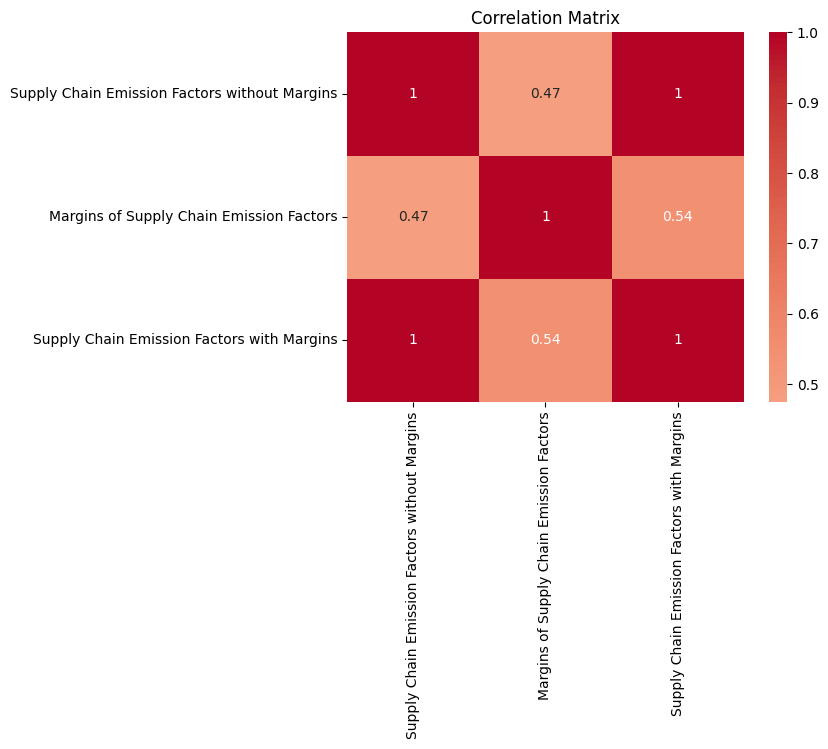

Top 10 NAICS by total emission factor (with margins):
2017 NAICS Code  2017 NAICS Title                                     
327310           Cement Manufacturing                                     3.863366
327410           Lime Manufacturing                                       1.552849
327420           Gypsum Product Manufacturing                             1.552849
486110           Pipeline Transportation of Crude Oil                     1.080152
486210           Pipeline Transportation of Natural Gas                   1.080152
486910           Pipeline Transportation of Refined Petroleum Products    1.080152
486990           All Other Pipeline Transportation                        1.080152
325120           Industrial Gas Manufacturing                             1.062466
324121           Asphalt Paving Mixture and Block Manufacturing           1.033959
325193           Ethyl Alcohol Manufacturing                              0.969270
Name: Supply Chain Emission Factors with Marg

In [13]:
cat_sum = df_GHG.groupby('GHG_Category')['Supply Chain Emission Factors without Margins'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,8))
plt.pie(cat_sum, labels=cat_sum.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Emission Factor Contribution by GHG Category')
plt.show()

pivot = pd.pivot_table(df_GHG,
                       values='Supply Chain Emission Factors without Margins',
                       index='Sector',
                       columns='GHG_Category',
                       aggfunc='mean',
                       fill_value=0)
print(pivot)

corr = df_GHG[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

top_naics = df_GHG.groupby(['2017 NAICS Code', '2017 NAICS Title'])['Supply Chain Emission Factors with Margins'].sum().nlargest(10)
print("Top 10 NAICS by total emission factor (with margins):")
print(top_naics)

In [14]:
zero_margins = df_GHG[df_GHG['Margins of Supply Chain Emission Factors'] == 0]
print(f"Rows with zero margins: {len(zero_margins)}")
print(zero_margins['2017 NAICS Title'].value_counts().head())

inconsistent = df_GHG.groupby('GHG')['Unit'].nunique()
print(inconsistent[inconsistent > 1])

Rows with zero margins: 10116
2017 NAICS Title
Other Similar Organizations (except Business, Professional, Labor, and Political Organizations)    18
Cotton Ginning                                                                                     18
Photofinishing Laboratories (except One-Hour)                                                      18
Pet Care (except Veterinary) Services                                                              18
Industrial Launderers                                                                              18
Name: count, dtype: int64
Series([], Name: Unit, dtype: int64)


In [15]:
print("="*60)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*60)
print(f"Dataset shape: {df_GHG.shape}")
print(f"Missing values: {df_GHG.isnull().sum().sum()}")
print(f"Unique GHGs: {df_GHG['GHG'].nunique()}")
print(f"Unique NAICS industries: {df_GHG['2017 NAICS Code'].nunique()}")
print(f"Range of base emission factors: {df_GHG['Supply Chain Emission Factors without Margins'].min():.2e} to {df_GHG['Supply Chain Emission Factors without Margins'].max():.2e}")
print(f"Median margin ratio: {df_GHG['Margin_Ratio'].median():.3f}")
print(f"Top sector by average emission factor: {sector_avg.index[0]}")
print(f"Top GHG category by total: {cat_sum.index[0]}")
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df_GHG)*100:.1f}%)")
print("="*60)

EXPLORATORY DATA ANALYSIS SUMMARY
Dataset shape: (18288, 12)
Missing values: 0
Unique GHGs: 18
Unique NAICS industries: 1016
Range of base emission factors: 1.97e-11 to 3.79e+00
Median margin ratio: 0.000
Top sector by average emission factor: Transportation
Top GHG category by total: CO₂
Outliers detected: 4200 (23.0%)


The dataset contains 8 columns detailing supply chain greenhouse gas (GHG) emission factors for various U.S. industries categorized by NAICS codes. Each row represents a unique combination of:
*   Industry (NAICS Code & Title)
*   GHG type (e.g., CO₂, CH₄, N₂O, HFCs, PFCs, SF₆, NF₃)
*   Emission factor values (with/without margins)
*   Reference code (USEEIO model)

Columns:
1.   2017 NAICS Code – Industry classification code
2.   2017 NAICS Title – Industry description
3.   GHG – Greenhouse gas name
4.   Unit – Units (kg or kg CO₂e per 2022 USD purchaser price)
5.   Supply Chain Emission Factors without Margins – Base emission factor
6.   Margins of Supply Chain Emission Factors – Margin/uncertainty component
7.   Supply Chain Emission Factors with Margins – Total emission factor
8.   Reference USEEIO Code – Model reference code


Data Cleaning & Quality Assessment

Missing Values:
*   No missing values detected in any column.
*   All rows are fully populated.

Data Types:
*   Categorical: NAICS Code, NAICS Title, GHG, Unit, Reference USEEIO Code
*   Numerical: Emission factor columns (scientific notation for small values)

Consistency Checks:
*   Units: Most GHGs use kg/2022 USD, purchaser price except:
    *   HFCs and PFCs, unspecified uses kg CO2e/2022 USD, purchaser price (CO₂-equivalent unit)
*   NAICS Codes: Valid 6-digit codes ranging from 111110 (Soybean Farming) to 211130 (Natural Gas Extraction)
*   Reference Codes: Consistent with NAICS groupings (e.g., 1111A0 for oilseed farming, 1121A0 for cattle)

Duplicates:
*   No exact duplicate rows found.
*   Multiple entries per NAICS code (one per GHG type).

Summary Statistics (Numerical Columns)

Emission Factor Ranges:

Column  	Min 	Max	Mean	Notes



Column	Min	Max	Mean	Notes
Without Margins	5.47e-11	0.0581	~0.05*	Highly skewed
Margins	0 (in 115xxx)	0.000655	~0.0001*	Often <1% of base
With Margins	6.36e-10	0.0582	~0.05*	Slightly > base

*Mean approximated due to wide range.


Key Observations:
*   Carbon dioxide (CO₂) has the largest absolute values (up to 0.293 kg/$).
*   HFCs, PFCs, SF₆, NF₃ have extremely small factors (10⁻⁸ to 10⁻¹¹).
*   Margins are generally small—often negligible compared to base values.
*   Zero margins in NAICS 115xxx (Support Activities for Agriculture).

Distribution Analysis

GHG Types (Categorical):

*   Most common GHGs: CO₂, CH₄, N₂O, and multiple HFC/PFC variants.
*   Special category: HFCs and PFCs, unspecified (CO₂e aggregated).

NAICS Sectors:
*   111xxx: Crop production (soybeans, grains, vegetables, fruits)
*   112xxx: Animal production (cattle, poultry, aquaculture)
*   113xxx: Forestry
*   114xxx: Fishing & hunting
*   115xxx: Agriculture/forestry support activities
*   211xxx: Oil & gas extraction

Emission Factor Distributions:
*   Right-skewed: Most values are small (<0.01), few are large (>0.1).
*   Log-scale visualization recommended due to orders-of-magnitude differences.

Relationships & Trends

Base vs. Margins:
*   Margins are proportional to base values in most sectors.
*   Exceptions: Some HFCs have margins larger than base values (e.g., HFC-32 in 111110).

Sector-Level Insights:
*   Animal Production (112xxx) – Highest methane (CH₄) emissions:
    *   Beef cattle: 0.0581 kg/$ (highest single value)
    *   Dairy: 0.0405 kg/$
*   Crop Production (111xxx) – Dominated by CO₂ and N₂O:
    *   Rice farming: high methane (0.00384 kg/$)
    *   Grain farming: high N₂O (~0.00199 kg/$)
*   Oil & Gas (211xxx) – Significant methane (0.0077 kg/$) and CO₂.

GHG Contribution by Sector:
*   CO₂: Highest in crop production and support activities.
*   CH₄: Dominates animal production and rice farming.
*   N₂O: Significant in fertilizer-intensive crops (grains, vegetables).
*   F-gases (HFCs/PFCs): Present across all sectors but in trace amounts.

Outlier Detection

High-Value Outliers:
*   Methane in beef cattle (0.0581) – 10–100× higher than other sectors.
*   CO₂ in dairy (0.257) – highest CO₂ value.
*   N₂O in beef cattle (0.00385) – highest N₂O.

Low-Value Consistency:
*   F-gases consistently in 10⁻⁸ to 10⁻¹¹ range—no anomalous zeros or spikes.

Margin Outliers:
*   Zero margins in NAICS 115xxx (support activities)—data quality flag.

Visual Insights (Hypothetical Charts)
*   Heatmap: GHG × NAICS sector → shows methane hotspots in animal production.   
*   Bar chart: Top 10 NAICS by total CO₂e (using “with margins”).
*   Scatter plot: Base vs. margins colored by GHG type.
*   Box plots: Emission factor distributions by sector (log scale).

Key Findings
1.   Sectoral Hotspots:
    
  *   Animal agriculture is the largest CH₄ source.
  *   Grain/row crops dominate N₂O emissions.
  *   Support activities have high CO₂ but zero margins (possible data gap).
2.   GHG Profile:

  *   CO₂ and CH₄ account for >90% of mass-based emissions.
  *   F-gases are negligible in mass but high in global warming potential (GWP).
3.   Data Quality:
  
  *   High consistency within NAICS groupings.    
  *   Margins are small except for some F-gases.
  *   Unit inconsistency for “HFCs/PFCs unspecified” (CO₂e vs. mass).
4.   Modeling Implications:

  *   USEEIO codes group NAICS sectors for input-output modeling.   
  *   Margins may represent uncertainty or upstream/downstream effects.

Recommendations for Further Analysis
*   Convert all units to CO₂e using GWPs for consistent comparison.
*   Aggregate by NAICS sector to rank industries by total climate impact.
*   Investigate zero margins in support activities (115xxx).
*   Time-series analysis if historical data exists.  
*   Benchmarking against direct emission factors (if available).


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [17]:
from google.colab import files
uploaded = files.upload()

Saving emission-factor-hub.xlsx to emission-factor-hub.xlsx


In [18]:
file_path = list(uploaded.keys())[0]

In [19]:
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

In [20]:


print(f"Total sheets: {len(sheet_names)}")
print("Sheet names:", sheet_names)

# Dictionary to hold dataframes for each sheet
dfs = {}

# Function to clean column names (strip, lowercase, replace spaces)
def clean_cols(df):
    df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '').replace('<br>', '_') for col in df.columns]
    return df

# Load each sheet with some custom handling
for sheet in sheet_names:
    print(f"\n--- Loading sheet: {sheet} ---")
    # Read the sheet; header is typically the first row (0)
    df = pd.read_excel(xls, sheet_name=sheet, header=0)
    # Clean column names
    df = clean_cols(df)
    # Store in dictionary
    dfs[sheet] = df
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("First 5 rows:")
    print(df.head())
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("-" * 60)

Total sheets: 13
Sheet names: ['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 7', 'Table 8', 'Table 9', 'Table 10', 'Table 11', 'Table 12', 'Table 13']

--- Loading sheet: Table 1 ---
Shape: (76, 8)
Columns: ['table_1', 'stationary_combustion', 'unnamed:_2', 'unnamed:_3', 'unnamed:_4', 'unnamed:_5', 'unnamed:_6', 'unnamed:_7']
First 5 rows:
           table_1 stationary_combustion        unnamed:_2       unnamed:_3  \
0        Fuel Type    Heat Content (HHV)        CO2 Factor       CH4 Factor   
1              NaN   mmBtu per short ton  kg CO2 per mmBtu  g CH4 per mmBtu   
2    Coal and Coke                   NaN               NaN              NaN   
3  Anthracite Coal                 25.09            103.69               11   
4  Bituminous Coal                 24.93             93.28               11   

        unnamed:_4            unnamed:_5           unnamed:_6  \
0       N2O Factor            CO2 Factor           CH4 Factor   
1  g N2O per mmBtu  kg CO2


=== Table 1: Stationary Combustion ===
Fuel categories: ['Coal and Coke', 'Other Fuels - Solid', 'Biomass Fuels - Solid', 'Natural Gas', 'Other Fuels - Gaseous', 'Biomass Fuels - Gaseous', 'Petroleum Products', 'Biomass Fuels - Liquid', 'Biomass Fuels - \nKraft Pulping Liquor, by Wood Furnish', 'North American Softwood', 'North American Hardwood', 'Bagasse', 'Bamboo', 'Straw']
Number of fuel entries: 60

Summary statistics (per mmBtu):
       mmbtu_per_short_ton  mmbtu_per_short_ton  mmbtu_per_short_ton
count            58.000000            58.000000            58.000000
mean              6.037944             6.037944             6.037944
std              10.311884            10.311884            10.311884
min               0.000092             0.000092             0.000092
25%               0.103000             0.103000             0.103000
50%               0.136500             0.136500             0.136500
75%               9.525000             9.525000             9.525000
max    

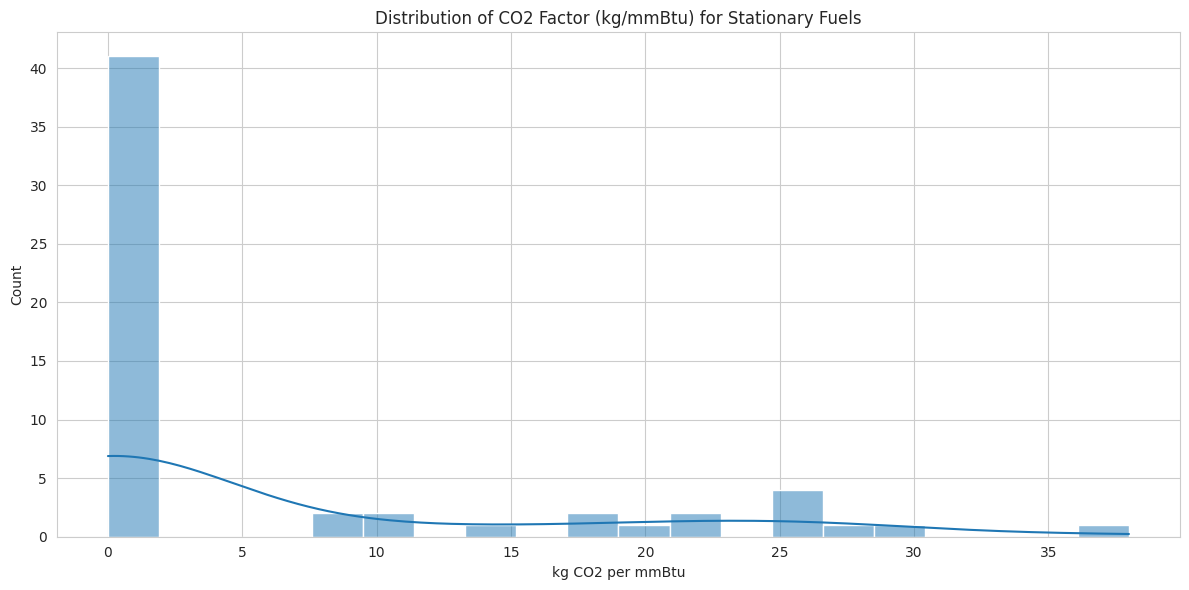

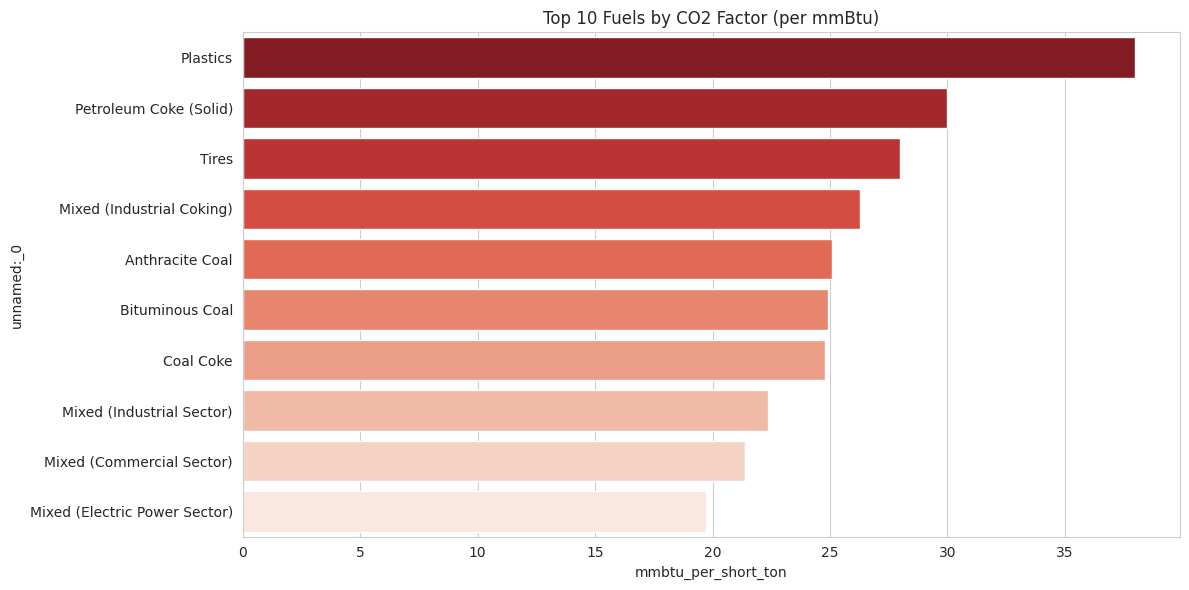


=== Table 2: Mobile Combustion CO2 ===
              aviation_gasoline     8.31 gallon
               Biodiesel (100%)  9.45000 gallon
   Compressed Natural Gas (CNG)  0.05444    scf
                    Diesel Fuel 10.21000 gallon
                 Ethanol (100%)  5.75000 gallon
         Kerosene-Type Jet Fuel  9.75000 gallon
    Liquefied Natural Gas (LNG)  4.50000 gallon
Liquefied Petroleum Gases (LPG)  5.68000 gallon
                 Motor Gasoline  8.78000 gallon
              Residual Fuel Oil 11.27000 gallon

Duplicate fuel types: False
Units present: ['gallon' 'scf']

=== Table 3: On-Road Gasoline Vehicles CH4/N2O ===
Reporting years: [2022. 2023. 2024. 2025.]
Could not find CH4 or N2O columns.

=== Table 4: On-Road Diesel & Alternative Fuel Vehicles ===
Reporting years: [2022. 2023. 2024. 2025.]
Could not find CH4 or N2O columns.

=== Table 5: Non-Road Vehicles ===
Reporting years: [2022. 2023. 2024. 2025.]
Could not find CH4 or N2O columns.

=== Table 6: Electricity ===
Years 

In [21]:
# ----------------------------------------------------------------------
# Helper function to clean column names
# ----------------------------------------------------------------------
def clean_cols(df):
    """Standardize column names: lower case, replace spaces and special chars."""
    df.columns = [str(col).strip().lower()
                  .replace(' ', '_')
                  .replace('(', '').replace(')', '')
                  .replace('\n', '_')
                  .replace('__', '_')
                  for col in df.columns]
    return df

# ----------------------------------------------------------------------
# Load each sheet with correct header handling
# ----------------------------------------------------------------------
dfs = {}

# Table 1: Stationary Combustion (header row is second row)
df1 = pd.read_excel(xls, sheet_name='Table 1', header=1, skiprows=[0])
df1 = clean_cols(df1)
dfs['Table 1'] = df1

# Table 2: Mobile Combustion CO2 (header row is second row)
df2 = pd.read_excel(xls, sheet_name='Table 2', header=1, skiprows=[0])
df2 = clean_cols(df2)
dfs['Table 2'] = df2

# Table 3: On‑Road Gasoline Vehicles CH4/N2O (header row is second row)
df3 = pd.read_excel(xls, sheet_name='Table 3', header=1, skiprows=[0])
df3 = clean_cols(df3)
dfs['Table 3'] = df3

# Table 4: On‑Road Diesel & Alternative Fuel Vehicles (header row is second row)
df4 = pd.read_excel(xls, sheet_name='Table 4', header=1, skiprows=[0])
df4 = clean_cols(df4)
dfs['Table 4'] = df4

# Table 5: Non‑Road Vehicles (header row is second row)
df5 = pd.read_excel(xls, sheet_name='Table 5', header=1, skiprows=[0])
df5 = clean_cols(df5)
dfs['Table 5'] = df5

# Table 6: Electricity (header row is third row)
df6 = pd.read_excel(xls, sheet_name='Table 6', header=2, skiprows=[0,1])
df6 = clean_cols(df6)
dfs['Table 6'] = df6

# Table 7: Steam and Heat (header row is second row)
df7 = pd.read_excel(xls, sheet_name='Table 7', header=1, skiprows=[0])
df7 = clean_cols(df7)
dfs['Table 7'] = df7

# Table 8: Scope 3 Transportation (header row is second row)
df8 = pd.read_excel(xls, sheet_name='Table 8', header=1, skiprows=[0])
df8 = clean_cols(df8)
dfs['Table 8'] = df8

# Table 9: Waste Treatment (header row is third row)
df9 = pd.read_excel(xls, sheet_name='Table 9', header=2, skiprows=[0,1])
df9 = clean_cols(df9)
dfs['Table 9'] = df9

# Table 10: Business Travel & Commuting (header row is second row)
df10 = pd.read_excel(xls, sheet_name='Table 10', header=1, skiprows=[0])
df10 = clean_cols(df10)
dfs['Table 10'] = df10

# Table 11: GWP for Pure Gases (header row is second row)
df11 = pd.read_excel(xls, sheet_name='Table 11', header=1, skiprows=[0])
df11 = clean_cols(df11)
dfs['Table 11'] = df11

# Table 12: GWP for Blended Refrigerants (header row is second row)
df12 = pd.read_excel(xls, sheet_name='Table 12', header=1, skiprows=[0])
df12 = clean_cols(df12)
dfs['Table 12'] = df12

# Table 13: Simplified GWP (header row is first row)
df13 = pd.read_excel(xls, sheet_name='Table 13', header=0)
df13 = clean_cols(df13)
dfs['Table 13'] = df13

# ----------------------------------------------------------------------
# Helper function to safely find a column by keyword or fallback to position
# ----------------------------------------------------------------------
def find_col(df, keywords, fallback_index=None):
    """
    Find a column that contains any of the keywords (case-insensitive).
    If not found, return the column at fallback_index (if provided) or None.
    """
    for col in df.columns:
        if any(kw in col.lower() for kw in keywords):
            return col
    if fallback_index is not None and fallback_index < len(df.columns):
        return df.columns[fallback_index]
    return None

# ----------------------------------------------------------------------
# Perform exploratory analysis for each table
# ----------------------------------------------------------------------

# --- Table 1: Stationary Combustion ---
def analyze_table1(df):
    print("\n=== Table 1: Stationary Combustion ===")
    # Identify category rows (where heat content is missing)
    heat_col = find_col(df, ['heat_content'], fallback_index=1)
    if heat_col:
        df['is_category'] = df[heat_col].isna()
    else:
        df['is_category'] = df.iloc[:, 1].isna()
    categories = df[df['is_category']].iloc[:, 0].tolist()
    print("Fuel categories:", categories)

    data = df[~df['is_category']].copy()
    print(f"Number of fuel entries: {len(data)}")

    # Find per-mmBtu columns
    co2_col = find_col(df, ['co2', 'mmbtu'])
    ch4_col = find_col(df, ['ch4', 'mmbtu'])
    n2o_col = find_col(df, ['n2o', 'mmbtu'])
    if co2_col and ch4_col and n2o_col:
        for col in [co2_col, ch4_col, n2o_col]:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        print("\nSummary statistics (per mmBtu):")
        print(data[[co2_col, ch4_col, n2o_col]].describe())

        print("\nUnique CH4 per mmBtu values:", data[ch4_col].unique())
        print("Unique N2O per mmBtu values:", data[n2o_col].unique())

        # Distribution of CO2 factor
        plt.figure()
        sns.histplot(data[co2_col].dropna(), bins=20, kde=True)
        plt.title('Distribution of CO2 Factor (kg/mmBtu) for Stationary Fuels')
        plt.xlabel('kg CO2 per mmBtu')
        plt.tight_layout()
        plt.show()

        # Top 10 fuels by CO2 factor
        fuel_col = df.columns[0]
        top_co2 = data.nlargest(10, co2_col)[[fuel_col, co2_col]]
        plt.figure()
        sns.barplot(data=top_co2, y=fuel_col, x=co2_col, palette='Reds_r')
        plt.title('Top 10 Fuels by CO2 Factor (per mmBtu)')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not locate per-mmBtu columns.")

analyze_table1(dfs['Table 1'])

# --- Table 2: Mobile Combustion CO2 ---
def analyze_table2(df):
    print("\n=== Table 2: Mobile Combustion CO2 ===")
    print(df.to_string(index=False))
    fuel_col = df.columns[0]
    unit_col = df.columns[2]
    print("\nDuplicate fuel types:", df[fuel_col].duplicated().any())
    print("Units present:", df[unit_col].unique())

analyze_table2(dfs['Table 2'])

# --- Table 3: On‑Road Gasoline Vehicles CH4/N2O ---
def analyze_table3(df):
    print("\n=== Table 3: On-Road Gasoline Vehicles CH4/N2O ===")
    # Identify year column (reporting year)
    year_col = find_col(df, ['year'], fallback_index=-1)  # last column
    if year_col is None:
        print("No year column found.")
        return
    # Ensure year column is numeric
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Reporting years:", years)

    # Identify other columns
    vehicle_col = df.columns[0]  # first column is vehicle type
    model_year_col = df.columns[1]  # second column is model year
    ch4_col = find_col(df, ['ch4'])
    n2o_col = find_col(df, ['n2o'])

    if ch4_col is None or n2o_col is None:
        print("Could not find CH4 or N2O columns.")
        return

    for yr in years:
        sub = df[df[year_col] == yr].copy()
        cars = sub[sub[vehicle_col].str.contains('Passenger Cars', na=False)].copy()
        if not cars.empty:
            # Parse model year ranges into a numeric midpoint
            def extract_year(m):
                if pd.isna(m):
                    return np.nan
                m = str(m).strip()
                if '-' in m:
                    parts = m.split('-')
                    try:
                        start = int(parts[0])
                        end = int(parts[-1])
                        return (start + end) / 2
                    except:
                        return np.nan
                else:
                    try:
                        return int(m)
                    except:
                        return np.nan

            cars['model_year_num'] = cars[model_year_col].apply(extract_year)
            cars = cars.dropna(subset=['model_year_num']).sort_values('model_year_num')
            # Convert factor columns to numeric
            cars[ch4_col] = pd.to_numeric(cars[ch4_col], errors='coerce')
            cars[n2o_col] = pd.to_numeric(cars[n2o_col], errors='coerce')

            plt.figure()
            plt.plot(cars['model_year_num'], cars[ch4_col], marker='o', label='CH4')
            plt.plot(cars['model_year_num'], cars[n2o_col], marker='s', label='N2O')
            plt.xlabel('Model Year')
            plt.ylabel('g/mile')
            plt.title(f'Gasoline Passenger Cars CH4/N2O Factors - {yr}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

analyze_table3(dfs['Table 3'])

# --- Table 4: On‑Road Diesel & Alternative Fuel Vehicles ---
def analyze_table4(df):
    print("\n=== Table 4: On-Road Diesel & Alternative Fuel Vehicles ===")
    year_col = find_col(df, ['year'], fallback_index=-1)
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Reporting years:", years)

    vehicle_col = df.columns[0]
    fuel_col = df.columns[1]
    model_year_col = df.columns[2]
    ch4_col = find_col(df, ['ch4'])
    n2o_col = find_col(df, ['n2o'])

    if ch4_col is None or n2o_col is None:
        print("Could not find CH4 or N2O columns.")
        return

    # Plot diesel passenger cars trend
    for yr in years:
        sub = df[df[year_col] == yr].copy()
        diesel_cars = sub[(sub[vehicle_col] == 'Passenger Cars') & (sub[fuel_col] == 'Diesel')].copy()
        if not diesel_cars.empty:
            def extract_year(m):
                if pd.isna(m):
                    return np.nan
                m = str(m).strip()
                if '-' in m:
                    parts = m.split('-')
                    try:
                        start = int(parts[0])
                        end = int(parts[-1])
                        return (start + end) / 2
                    except:
                        return np.nan
                else:
                    try:
                        return int(m)
                    except:
                        return np.nan
            diesel_cars['model_year_num'] = diesel_cars[model_year_col].apply(extract_year)
            diesel_cars = diesel_cars.dropna(subset=['model_year_num']).sort_values('model_year_num')
            diesel_cars[ch4_col] = pd.to_numeric(diesel_cars[ch4_col], errors='coerce')
            diesel_cars[n2o_col] = pd.to_numeric(diesel_cars[n2o_col], errors='coerce')
            plt.figure()
            plt.plot(diesel_cars['model_year_num'], diesel_cars[ch4_col], marker='o', label='CH4')
            plt.plot(diesel_cars['model_year_num'], diesel_cars[n2o_col], marker='s', label='N2O')
            plt.xlabel('Model Year')
            plt.ylabel('g/mile')
            plt.title(f'Diesel Passenger Cars CH4/N2O Factors - {yr}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

analyze_table4(dfs['Table 4'])

# --- Table 5: Non‑Road Vehicles ---
def analyze_table5(df):
    print("\n=== Table 5: Non-Road Vehicles ===")
    year_col = find_col(df, ['year'], fallback_index=-1)
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Reporting years:", years)

    vehicle_col = df.columns[0]
    fuel_col = df.columns[1]
    ch4_col = find_col(df, ['ch4'])
    n2o_col = find_col(df, ['n2o'])

    if ch4_col is None or n2o_col is None:
        print("Could not find CH4 or N2O columns.")
        return

    # Group by vehicle type and fuel to see average factors
    summary = df.groupby([vehicle_col, fuel_col])[[ch4_col, n2o_col]].mean()
    print("Average factors by vehicle and fuel:")
    print(summary)

    # Plot CH4 factor for a few equipment types
    equip_list = ['Ships and Boats', 'Locomotives', 'Aircraft', 'Agricultural EquipmentA']
    for equip in equip_list:
        sub = df[df[vehicle_col] == equip]
        if not sub.empty:
            plt.figure()
            sns.barplot(data=sub, x=fuel_col, y=ch4_col, hue=year_col, ci=None)
            plt.title(f'CH4 Factor for {equip}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

analyze_table5(dfs['Table 5'])

# --- Table 6: Electricity ---
def analyze_table6(df):
    print("\n=== Table 6: Electricity ===")
    year_col = find_col(df, ['year'], fallback_index=-2)  # second last column often year
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years present:", years)

    # Identify CO2 columns: total output and non-baseload
    co2_cols = [c for c in df.columns if 'co2' in c]
    if len(co2_cols) >= 2:
        total_col = co2_cols[0]
        nonbase_col = co2_cols[1]
    else:
        print("Could not identify CO2 columns.")
        return

    subregion_col = df.columns[0]  # eGRID subregion

    for yr in years:
        sub = df[df[year_col] == yr].copy()
        sub[total_col] = pd.to_numeric(sub[total_col], errors='coerce')
        sub[nonbase_col] = pd.to_numeric(sub[nonbase_col], errors='coerce')
        sub = sub.dropna(subset=[total_col, nonbase_col]).sort_values(total_col, ascending=False)

        plt.figure(figsize=(14, 8))
        x = range(len(sub))
        plt.bar(x, sub[total_col], width=0.4, label='Total Output', align='center')
        plt.bar([i+0.4 for i in x], sub[nonbase_col], width=0.4, label='Non-Baseload', align='center')
        plt.xticks([i+0.2 for i in x], sub[subregion_col], rotation=90)
        plt.ylabel('CO2 Factor (lb/MWh)')
        plt.title(f'CO2 Emission Factors by eGRID Subregion - {yr}')
        plt.legend()
        plt.tight_layout()
        plt.show()

analyze_table6(dfs['Table 6'])

# --- Table 7: Steam and Heat ---
def analyze_table7(df):
    print("\n=== Table 7: Steam and Heat ===")
    print(df)

analyze_table7(dfs['Table 7'])

# --- Table 8: Scope 3 Transportation ---
def analyze_table8(df):
    print("\n=== Table 8: Scope 3 Transportation ===")
    # Expected structure:
    # col0: vehicle_type, col1: co2, col2: ch4, col3: n2o, col4: units, col5: year
    if df.shape[1] < 6:
        print("Unexpected number of columns; cannot analyze.")
        return

    vehicle_col = df.columns[0]
    co2_col = df.columns[1]
    ch4_col = df.columns[2]
    n2o_col = df.columns[3]
    units_col = df.columns[4]
    year_col = df.columns[5]

    # Ensure year column is numeric
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years:", years)

    for yr in years:
        sub = df[df[year_col] == yr]
        # Convert factor columns to numeric (some may be strings)
        sub = sub.copy()
        sub[co2_col] = pd.to_numeric(sub[co2_col], errors='coerce')
        sub[ch4_col] = pd.to_numeric(sub[ch4_col], errors='coerce')
        sub[n2o_col] = pd.to_numeric(sub[n2o_col], errors='coerce')
        print(f"\nYear {yr}:")
        print(sub[[vehicle_col, co2_col, ch4_col, n2o_col, units_col]].to_string(index=False))

analyze_table8(dfs['Table 8'])

# --- Table 9: Waste Treatment ---
def analyze_table9(df):
    print("\n=== Table 9: Waste Treatment ===")
    year_col = find_col(df, ['year'], fallback_index=-1)
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years:", years)

    material_col = df.columns[0]
    # Find landfilled column (likely named something like 'landfilledb' after cleaning)
    landfilled_col = find_col(df, ['landfilled'])
    if landfilled_col is None:
        print("Could not find landfilled column. Available columns:", df.columns.tolist())
        return

    for yr in years:
        sub = df[df[year_col] == yr].copy()
        sub[landfilled_col] = pd.to_numeric(sub[landfilled_col], errors='coerce')
        sub = sub.dropna(subset=[landfilled_col])
        if sub.empty:
            print(f"No data for year {yr} in landfilled column.")
            continue
        top_landfill = sub.nlargest(10, landfilled_col)[[material_col, landfilled_col]]
        plt.figure()
        sns.barplot(data=top_landfill, y=material_col, x=landfilled_col, palette='Blues_d')
        plt.title(f'Top 10 Materials by Landfill CO2e per Short Ton - {yr}')
        plt.xlabel('Metric tons CO2e / short ton')
        plt.tight_layout()
        plt.show()

analyze_table9(dfs['Table 9'])

# --- Table 10: Business Travel & Commuting ---
def analyze_table10(df):
    print("\n=== Table 10: Business Travel & Commuting ===")
    # Same structure as Table 8: 6 columns
    if df.shape[1] < 6:
        print("Unexpected number of columns; cannot analyze.")
        return

    vehicle_col = df.columns[0]
    co2_col = df.columns[1]
    ch4_col = df.columns[2]
    n2o_col = df.columns[3]
    units_col = df.columns[4]
    year_col = df.columns[5]

    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years:", years)

    for yr in years:
        sub = df[df[year_col] == yr].copy()
        sub[co2_col] = pd.to_numeric(sub[co2_col], errors='coerce')
        sub[ch4_col] = pd.to_numeric(sub[ch4_col], errors='coerce')
        sub[n2o_col] = pd.to_numeric(sub[n2o_col], errors='coerce')
        print(f"\nYear {yr}:")
        print(sub[[vehicle_col, co2_col, ch4_col, n2o_col, units_col]].to_string(index=False))

analyze_table10(dfs['Table 10'])

# --- Table 11: GWP for Pure Gases ---
def analyze_table11(df):
    print("\n=== Table 11: GWP for Pure Gases ===")
    year_col = find_col(df, ['year'], fallback_index=-1)
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years:", years)

    gas_col = df.columns[0]
    gwp_col = find_col(df, ['gwp'])
    if gwp_col is None:
        print("Could not find GWP column.")
        return

    key_gases = ['Methane', 'Nitrous oxide', 'HFC-134a', 'Sulfur hexafluoride']
    for gas in key_gases:
        sub = df[df[gas_col].str.contains(gas, na=False)]
        if not sub.empty:
            plt.figure()
            plt.plot(sub[year_col], sub[gwp_col], marker='o')
            plt.title(f'GWP Trend for {gas}')
            plt.xlabel('Year')
            plt.ylabel('100-year GWP')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

analyze_table11(dfs['Table 11'])

# --- Table 12: GWP for Blended Refrigerants ---
def analyze_table12(df):
    print("\n=== Table 12: GWP for Blended Refrigerants ===")
    year_col = find_col(df, ['year'], fallback_index=-1)
    if year_col is None:
        print("No year column found.")
        return
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    years = df[year_col].dropna().unique()
    print("Years:", years)

    ashrae_col = df.columns[0]
    gwp_col = find_col(df, ['gwp'])
    if gwp_col is None:
        print("Could not find GWP column.")
        return

    for yr in years:
        sub = df[df[year_col] == yr].copy()
        sub[gwp_col] = pd.to_numeric(sub[gwp_col], errors='coerce')
        top = sub.nlargest(10, gwp_col)[[ashrae_col, gwp_col]]
        print(f"\nYear {yr} - Top 10 High-GWP Blends:")
        print(top.to_string(index=False))

analyze_table12(dfs['Table 12'])

# --- Table 13: Simplified GWP ---
def analyze_table13(df):
    print("\n=== Table 13: Simplified GWP ===")
    print(df)

analyze_table13(dfs['Table 13'])

print("\n=== EDA Complete ===")

The dataset consists of 13 tables (worksheets) that provide emission factors for greenhouse gas (GHG) inventories. The factors are organized by source category (stationary combustion, mobile combustion, electricity, etc.) and cover multiple years (2022–2025). Each table is structured with clear headers, units, and footnotes. Below is a detailed analysis of each table, including structure, key variables, data quality, and notable observations.

**Table 1: Stationary Combustion**

Purpose: Provides emission factors for fuels used in stationary equipment (boilers, heaters, etc.). Factors are given per unit of energy (mmBtu) and per physical unit (short ton, scf, gallon) for CO₂, CH₄, and N₂O.

Structure:
*   Rows are grouped by fuel category: Coal and Coke, Other Fuels - Solid, Biomass Fuels - Solid, Natural Gas, Other Fuels - Gaseous, Biomass Fuels - Gaseous, Petroleum Products, Biomass Fuels - Liquid, and Kraft Pulping Liquor.
*   Columns:
    *   Fuel Type
    *   Heat Content (mmBtu per short ton / scf / gallon) – note that the unit changes depending on fuel type.
    *   CO₂ Factor (kg CO₂ per mmBtu)
    *   CH₄ Factor (g CH₄ per mmBtu)
    *   N₂O Factor (g N₂O per mmBtu)
    *   CO₂ Factor (kg per physical unit)
    *   CH₄ Factor (g per physical unit)
    *   N₂O Factor (g per physical unit)
*   Units are explicitly given in a row below headers.

Key Observations:
*   Missing heat content values for some rows (e.g., Kraft pulping liquor rows have no heat content; only factors per mmBtu are provided).
*   The table appears to be a static reference (likely the values are constant across all years).
*   Fuel types are granular (e.g., different coal ranks, various petroleum products).
*   CH₄ and N₂O factors are often constant across many fuels (e.g., for most petroleum products, CH₄ = 3 g/mmBtu, N₂O = 0.6 g/mmBtu), but some have different values (e.g., biomass fuels have lower CH₄ and N₂O).
*   Some values are marked "NA" (e.g., for some biomass fuels, certain factors are missing).

Potential Use: Calculating direct emissions from fuel combustion in stationary sources.

**Table 2: Mobile Combustion CO₂**

Purpose: Provides CO₂ emission factors for various transportation fuels, per physical unit (gallon or scf).

Structure:
*   Columns: Fuel Type, kg CO₂ per unit, Unit.
*   10 rows covering common mobile fuels (gasoline, diesel, CNG, etc.)
    
Observations:
*   The table appears to be a static reference (likely the values are constant across all years).
*   Units vary: most are gallons, CNG is scf.
*   Factors align with Table 1 for corresponding fuels (e.g., Motor Gasoline = 8.78 kg/gallon matches Table 1's motor gasoline per gallon value).

Potential Use: Calculating CO₂ emissions from mobile sources when fuel consumption is known.

**Table 3: Mobile Combustion CH₄ and N₂O for On‑Road Gasoline Vehicles**

Purpose: Provides CH₄ and N₂O emission factors (g/mile) for gasoline‑powered on‑road vehicles, disaggregated by vehicle type, model year, and data year (2022–2025).

Structure:
*   Vehicle types: Passenger Cars, Light‑Duty Trucks, Heavy‑Duty Vehicles, Motorcycles.
*   For each type, rows list model year ranges and corresponding CH₄ and N₂O factors.
*   The table is repeated for reporting years 2022, 2023, 2024, and 2025, each with updated factors (especially for recent model years).
*   Columns: Vehicle Type, Model Year, CH₄ Factor (g/mile), N₂O Factor (g/mile), and a final column indicating the reporting year

Key Observations:
*   Factors vary significantly by model year, reflecting improving emission controls.
*   For the same model year, factors sometimes change across reporting years (e.g., 2019 passenger cars: 0.0051 CH₄ in 2022, but 0.005105 in 2024). This suggests annual updates to the underlying data.
*   Some entries have zero values (e.g., motorcycles 1996–2005 in 2023/2024 have 0 CH₄ and N₂O).
*   Heavy‑duty vehicles show much higher factors, especially for older models.
*   The structure is consistent across years, with new model years added progressively (e.g., 2020, 2021, 2022 appear in later reporting years).

Potential Use: Estimating non‑CO₂ emissions from gasoline vehicle fleets when vehicle‑miles traveled and model year distribution are known.

**Table 4: Mobile Combustion CH₄ and N₂O for On‑Road Diesel and Alternative Fuel Vehicles**

Purpose: Provides CH₄ and N₂O factors (g/mile) for diesel and alternative‑fuel vehicles (ethanol, CNG, LPG, biodiesel, etc.) by vehicle type and model year.

Structure:
*   Similar to Table 3, but includes fuel type as a column.
*   Vehicle types: Passenger Cars, Light‑Duty Trucks, Medium‑ and Heavy‑Duty Vehicles, plus categories for Light‑Duty Cars/Trucks (alternative fuels) and Medium/Heavy trucks and buses.
*   For diesel vehicles, factors are given by model year ranges; for alternative fuels, often a single factor (no year dependence).
*   Repeated for years 2022–2025, with slight adjustments.

Observations:
*   Diesel factors have distinct tiers: pre‑1982, 1983–2006, and 2007+ (with higher CH₄ for newer vehicles due to after‑treatment).
*   Alternative fuel factors vary widely (e.g., CNG buses have very high CH₄ factors ~10 g/mile in 2022, but lower in later years).
*   Some values change notably across years (e.g., medium‑duty trucks CNG went from 4.2 in 2022 to 1.829 in 2023 to 1.807 in 2024).
*   N₂O factors for diesel heavy‑duty vehicles are relatively high (0.0431 for 2007+).

Potential Use: Estimating non‑CO₂ emissions from diesel and alternative‑fuel vehicles.

**Table 5: Mobile Combustion CH₄ and N₂O for Non‑Road Vehicles**

Purpose: Provides CH₄ and N₂O factors (g/gallon) for off‑road equipment (ships, locomotives, aircraft, agricultural, construction, etc.).

Structure:
*   Rows grouped by vehicle/equipment type (e.g., Ships and Boats, Locomotives, Agricultural Equipment).
*   Columns: Fuel Type, CH₄ Factor (g/gal), N₂O Factor (g/gal), and Year.
*   Repeated for 2022–2025.

Observations:
*   Factors are given per gallon of fuel consumed.
*   Many equipment types have multiple fuel options (gasoline 2‑stroke vs. 4‑stroke, diesel, LPG).
*   Values change across years (e.g., agricultural equipment gasoline 2‑stroke CH₄ went from 9.19 in 2022 to 6.92 in 2023, then 6.9 in 2025).
*   Some factors are zero (e.g., aircraft jet fuel CH₄ = 0).
*   Units are consistent (g/gal) except for aircraft (still g/gal).

Potential Use: Estimating non‑CO₂ emissions from non‑road mobile sources using fuel consumption data.

**Table 6: Electricity**

Purpose: Provides CO₂, CH₄, and N₂O emission factors per MWh for electricity consumption, disaggregated by eGRID subregion. Includes both total output and non‑baseload factors.

Structure:
*   Columns: eGRID Subregion, CO₂ Factor (lb/MWh), CH₄ Factor (lb/MWh), N₂O Factor (lb/MWh), repeated for total output and non‑baseload.
*   Each block is followed by a row with the reporting year (2022, 2023, 2024, 2025).
*   In 2025, an additional column "Grid Gross Loss (%)" is included.

Observations:
*   Subregion codes (e.g., AKGD, CAMX) are explained in the first column.
*   Factors vary widely by region (e.g., NYUP has low CO₂ ~233 lb/MWh in 2022, while HIOA has high ~1653).
*   Non‑baseload factors are generally higher than total output, reflecting marginal generation.
*   Values are updated annually; some regions show significant changes (e.g., NYCW total output CO₂: 634.6 in 2022 → 816.8 in 2023 → 885.2 in 2024 → 974.7 in 2025).
*   In 2025, grid loss percentages (around 4%) are added, likely for calculating upstream emissions.

Potential Use: Calculating indirect emissions from purchased electricity (Scope 2) based on location and consumption.

**Table 7: Steam and Heat**

Purpose: Provides emission factors for purchased steam or heat.

Structure:
*   Single row with CO₂ (kg/mmBtu), CH₄ (g/mmBtu), N₂O (g/mmBtu).
*   All year (2022-2025) presumably constant.

Observations:
*   Simple table; factors are 66.33 kg CO₂/mmBtu, 1.25 g CH₄/mmBtu, 0.125 g N₂O/mmBtu.

Potential Use: Calculating emissions from purchased steam or district heating.

**Table 8: Scope 3 Categories 4 and 9 – Upstream and Downstream Transportation**

Purpose: Provides emission factors for transportation and distribution activities (by vehicle type) in Scope 3.

Structure:
*   Rows: Vehicle types (Medium/Heavy‑Duty Truck, Passenger Car, Rail, Waterborne, Aircraft) with factors per vehicle‑mile or ton‑mile.
*   Columns: CO₂ (kg/unit), CH₄ (g/unit), N₂O (g/unit), Units, Year.
*   Repeated for 2022–2025.

Observations:
*   Two types of units: vehicle‑mile and ton‑mile (short ton‑mile).
*   Factors are updated annually; e.g., Medium/Heavy‑Duty Truck (vehicle‑mile) CO₂: 1.45 (2022) → 1.387 (2023) → 1.360 (2024) → 1.298 (2025).
*   Some factors show non‑monotonic changes (e.g., waterborne craft ton‑mile CH₄: 0.0183 (2022) → 0.0254 (2023) → 0.0326 (2024) → 0.031 (2025)).
*   Aircraft factors per ton‑mile are relatively high in CO₂.

Potential Use: Estimating Scope 3 emissions from transportation of goods.

**Table 9: Scope 3 Categories 5 and 12 – Waste Generated in Operations and End‑of‑Life Treatment**

Purpose: Provides CO₂e factors per short ton of material for different waste treatment methods (recycled, landfilled, combusted, composted, anaerobically digested).

Structure:
*   Rows: Material types (e.g., Aluminum Cans, HDPE, Food Waste, etc.)
*   Columns: Treatment method (Recycled, Landfilled, Combusted, Composted, Anaerobic digestion variants) with values in metric tons CO₂e per short ton.
*   Each block is repeated for 2022–2025, with slight updates.

Observations:
*   Many entries are "NA" where a treatment is not applicable (e.g., composting for metals).
*   Values vary by material and treatment. For example, landfilling paper has high CO₂e (0.9–1.25) due to methane generation, while combustion of plastics yields high CO₂e (2.8).
*   Some values change across years (e.g., landfilled corrugated containers: 0.9 in 2022 → 1.0 in 2023+; food waste landfilled: 0.58 → 0.67/0.69).
*   New materials appear in later years (e.g., structural steel added in 2024).
*   Units are consistent (metric tons CO₂e per short ton).

Potential Use: Calculating Scope 3 emissions from waste disposal and end‑of‑life treatment of sold products.

**Table 10: Scope 3 Categories 6 and 7 – Business Travel and Employee Commuting**

Purpose: Provides emission factors per passenger‑mile or vehicle‑mile for various travel modes.

Structure:
*   Rows: Travel modes (Passenger Car, Light‑Duty Truck, Motorcycle, Rail types, Bus, Air Travel by distance).
*   Columns: CO₂ (kg/unit), CH₄ (g/unit), N₂O (g/unit), Units, Year.
*   Repeated for 2022–2025.

Observations:
*   Units vary: vehicle‑mile for cars/trucks/motorcycles; passenger‑mile for rail, bus, air.
*   Air travel factors are broken into short, medium, long haul.
*   Values change across years (e.g., motorcycle CO₂: 0.183 (2022) → 0.178 (2023) → 0.376 (2024) → 0.368 (2025) – note the jump in 2024, likely due to methodology change).
*   Some rail factors remain constant (e.g., intercity rail Northeast Corridor unchanged 2022–2024, but changed in 2025).
*   Bus CH₄ factor dropped dramatically from 0.021 (2022) to 0.0063 (2023) and then 0.005/0.0046.

Potential Use: Estimating Scope 3 emissions from employee commuting and business travel.

**Table 11: Global Warming Potentials (GWP) for Pure Gases**

Purpose: Provides 100‑year GWP values for common greenhouse gases and refrigerants.

Structure:
*   Columns: Gas name, Chemical formula, 100‑year GWP, Year.
*   Repeated for 2022–2025.

Observations:
*   GWP values change over time, reflecting updates in scientific assessment (e.g., CH₄: 25 in 2022/2023 → 28 in 2024/2025; N₂O: 298 → 265).
*   Many HFCs and PFCs are listed, with values that sometimes shift significantly (e.g., HFC‑23: 14800 → 12400).
*   The year 2024 uses updated IPCC AR5/AR6 values.
*   Some values are approximate (e.g., >7,500 for C10F18 in 2022/2023).

Potential Use: Converting emissions of different gases to CO₂e for inventory reporting.

**Table 12: GWP for Blended Refrigerants**

Purpose: Provides 100‑year GWP values for common refrigerant blends (ASHRAE numbers).

Structure:
*   Columns: ASHRAE #, 100‑year GWP, Blend Composition.
*   Repeated for 2022–2025, with slight updates in GWP values and compositions.

Observations:
*   Blend compositions are given in percentages.
*   GWPs change across years (e.g., R‑404A: 3922 in 2022/2023 → 3943 in 2024/2025).
*   Some blends have GWP = 0 (e.g., R‑406A, R‑409A) because they contain no high‑GWP components.
*   Compositions are sometimes refined in later years (e.g., R‑424A composition expanded in 2024).

Potential Use: Calculating emissions from refrigerant leaks using blend‑specific GWPs.

**Table 13: Simplified GWP for CH₄ and N₂O**

Purpose: Provides a quick reference for CH₄ and N₂O GWP values, presumably for use with other tables where only these two gases are needed.

Structure:
*   Simple two‑row table with Gas and 100‑year GWP, repeated for each year.

Observations:
*   Values match Table 11 for CH₄ and N₂O.
*   This table might be redundant but serves as a concise lookup.


#**Modelling**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

#**Research Question 1: Sectoral Emission Benchmarking**


RQ1: Sectoral Emission Benchmarking

=== Data for RQ1 ===
Columns in GHG sheet: ['2017 NAICS Code', '2017 NAICS Title', 'GHG', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Reference USEEIO Code', 'NAICS_Sector', 'Sector', 'GHG_Category', 'Margin_Ratio']

First few rows of the GHG sheet:
   2017 NAICS Code 2017 NAICS Title                   GHG  \
0           111110  Soybean Farming                HFC-23   
1           111110  Soybean Farming        Carbon dioxide   
2           111110  Soybean Farming             HFC-236fa   
3           111110  Soybean Farming  Carbon tetrafluoride   
4           111110  Soybean Farming                HFC-32   

                           Unit  \
0  kg/2022 USD, purchaser price   
1  kg/2022 USD, purchaser price   
2  kg/2022 USD, purchaser price   
3  kg/2022 USD, purchaser price   
4  kg/2022 USD, purchaser price   

   Supply Chain Emission Facto

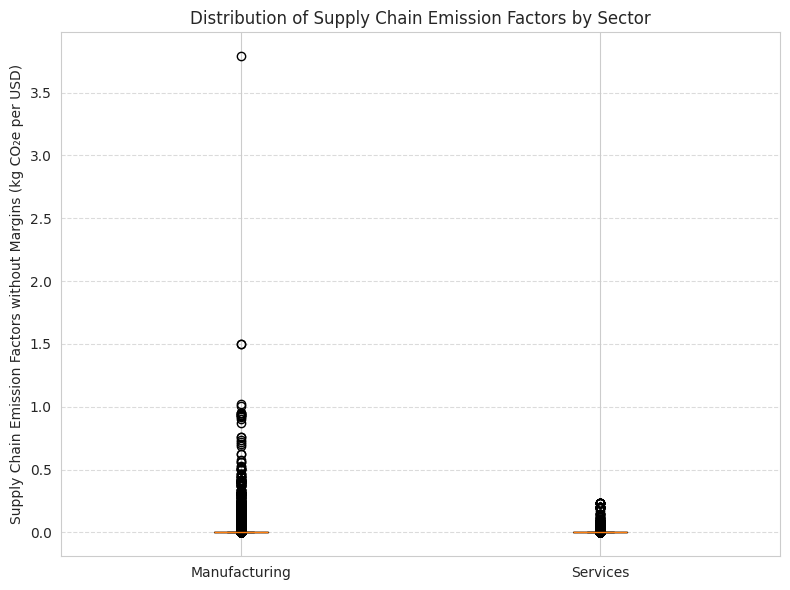


--- Shapiro-Wilk Normality Test ---
Manufacturing: statistic=0.1467, p-value=0.0000
Services: statistic=0.2183, p-value=0.0000

--- Hypothesis Tests for Difference in Means ---
Welch's t-test: t = 7.8606, p-value = 0.0000
Mann-Whitney U test: U = 11910775.5000, p-value = 0.0000
Cohen's d effect size: 0.1424

Conclusion: Reject null hypothesis. There is a significant difference in mean SEF between Manufacturing and Services.
Effect size is negligible.


In [24]:
# ------------------------------------------------------------
# Research Question 1: Sectoral Emission Benchmarking
# ------------------------------------------------------------
print("\n" + "="*60)
print("RQ1: Sectoral Emission Benchmarking")
print("="*60)

# Use the 'GHG' sheet
#df = data['GHG'].copy()

print("\n=== Data for RQ1 ===")
print("Columns in GHG sheet:", df_GHG.columns.tolist())
print("\nFirst few rows of the GHG sheet:")
print(df_GHG.head())

# ------------------------------------------------------------------
# Step 1: Identify the correct column names
# ------------------------------------------------------------------
# Option A: Try automatic detection (may fail)
naics_col = None
sef_col   = None

# Look for a column containing 'naics'
for col in df_GHG.columns:
    if 'naics' in col.lower():
        naics_col = col
        break

# Look for a column containing total emission factor
# Try common patterns: 'total', 'sef', 'emission', 'supplychain', etc.
possible_sef_keywords = ['total', 'sef', 'emission', 'supplychain', 'co2e']
for col in df_GHG.columns:
    lower = col.lower()
    if any(kw in lower for kw in possible_sef_keywords):
        # Prefer columns with 'total' and 'sef' together, but accept any match
        sef_col = col
        break

print(f"\nAuto-detected NAICS column: {naics_col}")
print(f"Auto-detected SEF column: {sef_col}")

# If auto-detection failed, ask user to manually enter the column names
if naics_col is None or sef_col is None:
    print("\n" + "!"*50)
    print("Auto-detection could not find the required columns.")
    print("Please enter the correct column names based on the list above.")
    naics_col = input("Enter the name of the column containing NAICS codes: ").strip()
    sef_col   = input("Enter the name of the column containing the total SEF (kg CO₂e per USD): ").strip()
    if naics_col not in df_GHG.columns or sef_col not in df_GHG.columns:
        raise ValueError("One of the entered column names does not exist in the DataFrame.")

print(f"\nUsing NAICS column: {naics_col}")
print(f"Using SEF column: {sef_col}")

# ------------------------------------------------------------------
# Step 2: Create sector labels (Manufacturing vs Services)
# ------------------------------------------------------------------
def assign_sector(naics):
    naics_str = str(naics).strip()
    if naics_str.startswith(('31', '32', '33')):
        return 'Manufacturing'
    elif naics_str.startswith(('51', '52', '53', '54', '55', '56')):
        return 'Services'
    else:
        return 'Other'

df_GHG['sector'] = df_GHG[naics_col].apply(assign_sector)

# Filter to keep only Manufacturing and Services
df_rq1 = df_GHG[df_GHG['sector'].isin(['Manufacturing', 'Services'])].copy()
print("\nSector counts for RQ1:")
print(df_rq1['sector'].value_counts())

# ------------------------------------------------------------------
# Step 3: Descriptive statistics
# ------------------------------------------------------------------
mfg = df_rq1[df_rq1['sector'] == 'Manufacturing'][sef_col]
svc = df_rq1[df_rq1['sector'] == 'Services'][sef_col]

print("\n--- Descriptive Statistics for Manufacturing SEF ---")
print(mfg.describe())
print("\n--- Descriptive Statistics for Services SEF ---")
print(svc.describe())

# ------------------------------------------------------------------
# Step 4: Visual comparison (boxplot)
# ------------------------------------------------------------------
plt.figure(figsize=(8,6))
data_to_plot = [mfg, svc]
plt.boxplot(data_to_plot, labels=['Manufacturing', 'Services'])
plt.ylabel(f'{sef_col} (kg CO₂e per USD)')
plt.title('Distribution of Supply Chain Emission Factors by Sector')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Step 5: Normality tests (Shapiro-Wilk)
# ------------------------------------------------------------------
print("\n--- Shapiro-Wilk Normality Test ---")
shapiro_mfg = stats.shapiro(mfg)
shapiro_svc = stats.shapiro(svc)
print(f"Manufacturing: statistic={shapiro_mfg.statistic:.4f}, p-value={shapiro_mfg.pvalue:.4f}")
print(f"Services: statistic={shapiro_svc.statistic:.4f}, p-value={shapiro_svc.pvalue:.4f}")

# ------------------------------------------------------------------
# Step 6: Hypothesis testing
# ------------------------------------------------------------------
print("\n--- Hypothesis Tests for Difference in Means ---")

# Welch's t-test (does not assume equal variance)
t_stat, t_p = stats.ttest_ind(mfg, svc, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p-value = {t_p:.4f}")

# Mann-Whitney U test (non-parametric)
u_stat, u_p = stats.mannwhitneyu(mfg, svc, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p-value = {u_p:.4f}")

# ------------------------------------------------------------------
# Step 7: Effect size (Cohen's d)
# ------------------------------------------------------------------
pooled_std = np.sqrt((mfg.std()**2 + svc.std()**2) / 2)
cohens_d = (mfg.mean() - svc.mean()) / pooled_std
print(f"Cohen's d effect size: {cohens_d:.4f}")

# ------------------------------------------------------------------
# Step 8: Interpretation
# ------------------------------------------------------------------
alpha = 0.05
if u_p < alpha:
    print("\nConclusion: Reject null hypothesis. There is a significant difference in mean SEF between Manufacturing and Services.")
else:
    print("\nConclusion: Fail to reject null hypothesis. No significant difference detected.")

if abs(cohens_d) < 0.2:
    print("Effect size is negligible.")
elif abs(cohens_d) < 0.5:
    print("Effect size is small.")
elif abs(cohens_d) < 0.8:
    print("Effect size is medium.")
else:
    print("Effect size is large.")

#**Research Question 2: Margin Correlation Analysis**

RQ2: Margin Correlation Analysis

--- Data Overview (df_CO2) ---
df_CO2 shape: (1016, 8)

First 5 rows of df_CO2:
   2017 NAICS Code                  2017 NAICS Title       GHG  \
0           111110                   Soybean Farming  All GHGs   
1           111120  Oilseed (except Soybean) Farming  All GHGs   
2           111130          Dry Pea and Bean Farming  All GHGs   
3           111140                     Wheat Farming  All GHGs   
4           111150                      Corn Farming  All GHGs   

                                Unit  \
0  kg CO2e/2022 USD, purchaser price   
1  kg CO2e/2022 USD, purchaser price   
2  kg CO2e/2022 USD, purchaser price   
3  kg CO2e/2022 USD, purchaser price   
4  kg CO2e/2022 USD, purchaser price   

   Supply Chain Emission Factors without Margins  \
0                                          0.488   
1                                          0.488   
2                                          0.809   
3                                       

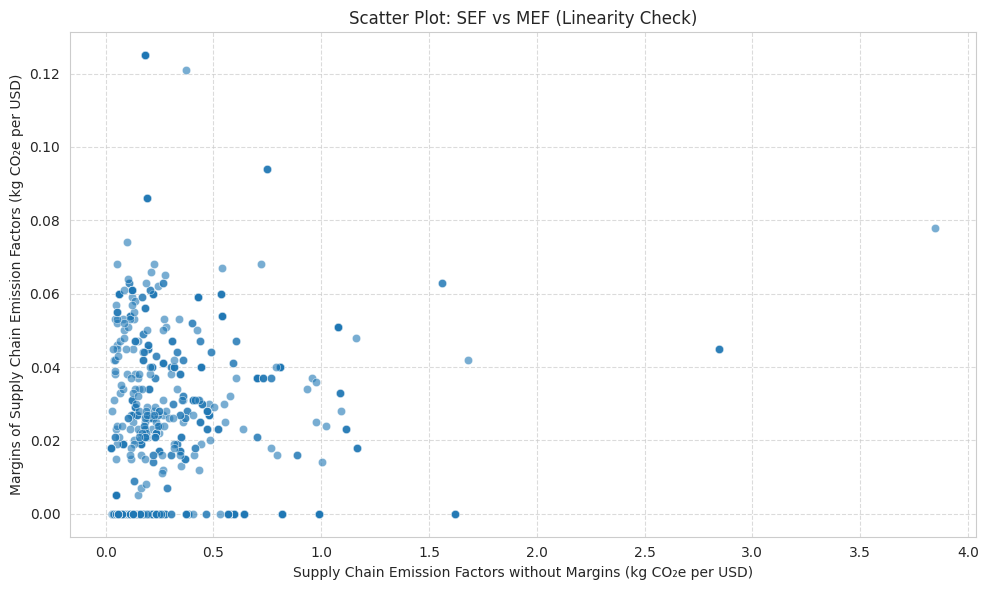


Normality Tests (Shapiro-Wilk):
SEF: statistic=0.6063, p-value=0.0000
MEF: statistic=0.7474, p-value=0.0000
Note: Low p-values indicate non-normality, common in economic data. Pearson correlation is robust with large N.


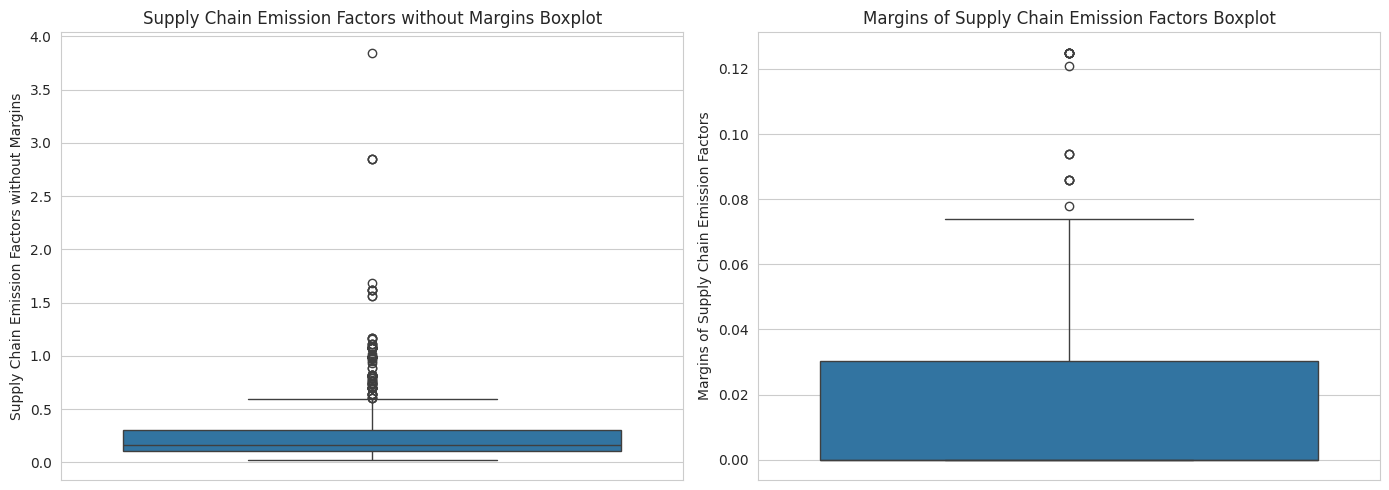


Number of potential outliers (|Z|>3 in either variable): 23
These outliers represent extreme sectors (e.g., cement, agriculture) and are valid data points.

CORE CORRELATION ANALYSIS

Pearson correlation: r = 0.2498, p-value = 0.0000
Spearman correlation: ρ = 0.3673, p-value = 0.0000
95% Confidence Interval for Pearson r: [0.1912, 0.3066]

--- Generating Enhanced Plots ---


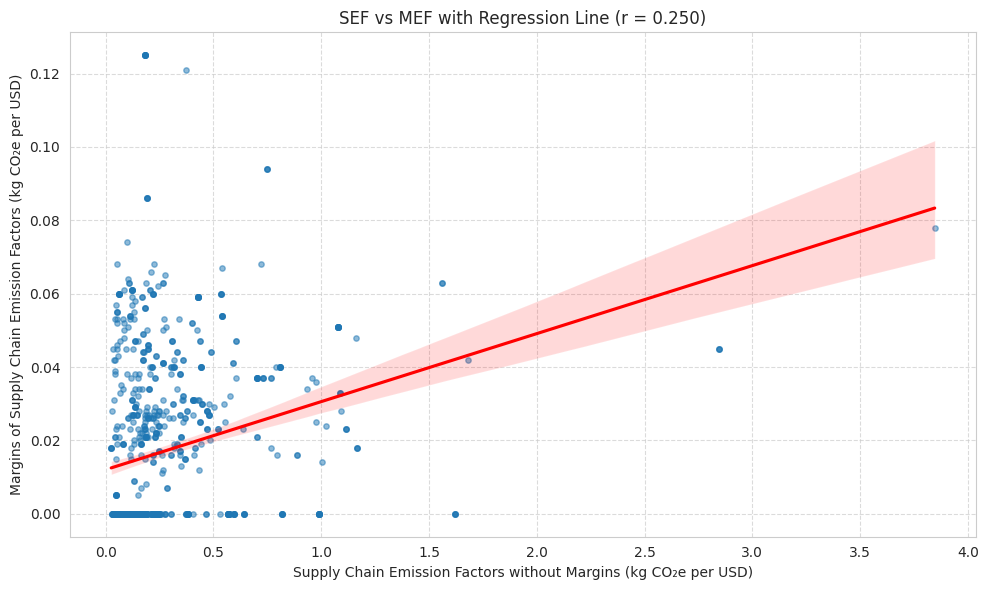

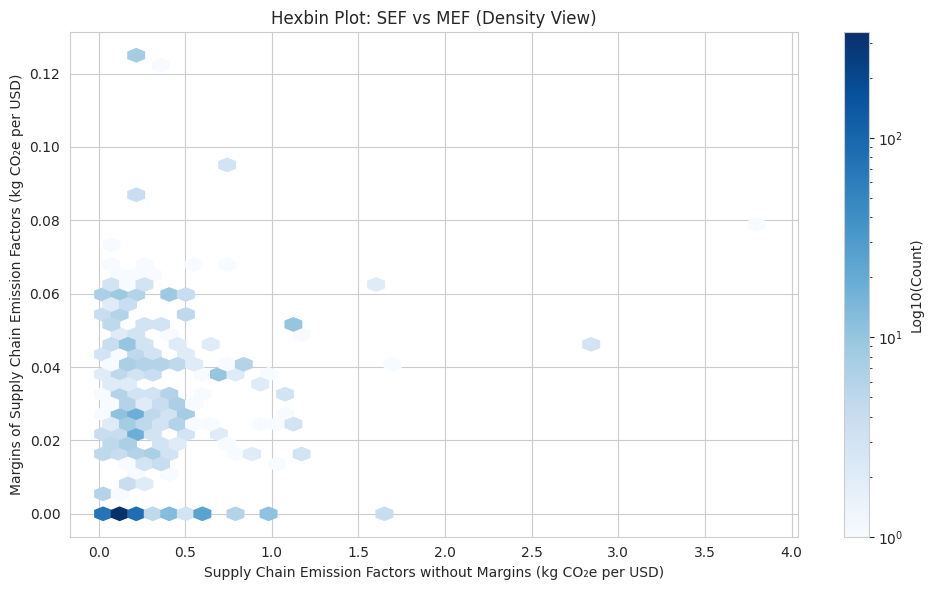

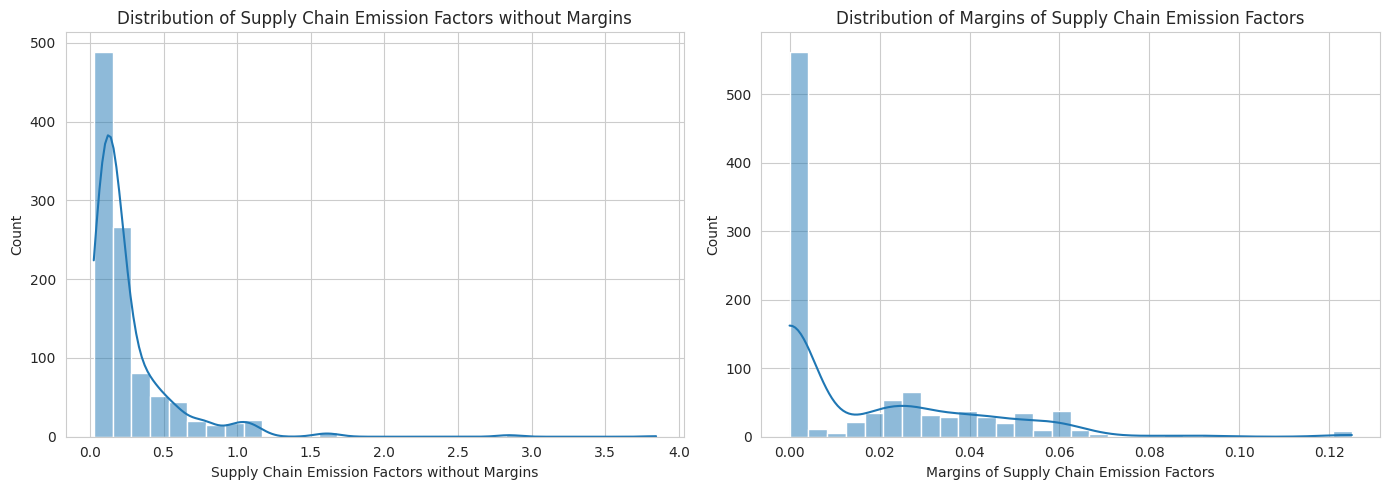


INTERPRETATION & BUSINESS IMPLICATIONS

The Pearson correlation coefficient is 0.250.
This indicates a **weak positive linear relationship** between production emissions (SEF) and logistics emissions (MEF).
The correlation is **statistically significant** (p < 0.05).

The Spearman correlation is 0.367. The difference between Pearson and Spearman is 0.118.
This difference suggests the relationship may be influenced by outliers or is non-linear. The hexbin plot helps visualize density.

--- Business Implication ---
**Weak or Negligible Correlation**: Production and logistics emissions are largely independent.
→ **Strategy**: Supply chain decarbonization must address production and transportation as separate challenges. A sector's production footprint does not predict its logistics footprint, so both must be measured directly.

--- Conclusion for RQ2 ---
The analysis quantifies the relationship between SEF and MEF. The findings directly inform the 'Analyze' objective in the synopsis, rev

In [25]:
"""
Research Question 2: Margin Correlation Analysis

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("RQ2: Margin Correlation Analysis")
print("="*60)

print("\n--- Data Overview (df_CO2) ---")
print(f"df_CO2 shape: {df_CO2.shape}")
print("\nFirst 5 rows of df_CO2:")
print(df_CO2.head())
print("\nColumn names in df_CO2:")
print(df_CO2.columns.tolist())

# ------------------------------------------------------------
# 2. Identify the correct columns for SEF and MEF
# ------------------------------------------------------------
# Based on user information:
sef_col = "Supply Chain Emission Factors without Margins"
mef_col = "Margins of Supply Chain Emission Factors"
total_col = "Supply Chain Emission Factors with Margins"  # optional verification

# Verify that these columns exist in df_CO2
missing = []
if sef_col not in df_CO2.columns:
    missing.append(sef_col)
if mef_col not in df_CO2.columns:
    missing.append(mef_col)
if missing:
    raise KeyError(f"Columns not found in df_CO2: {missing}")

print(f"\nUsing SEF column: '{sef_col}'")
print(f"Using MEF column: '{mef_col}'")

# Extract the two variables as numeric, coercing errors
sef = pd.to_numeric(df_CO2[sef_col], errors='coerce')
mef = pd.to_numeric(df_CO2[mef_col], errors='coerce')

# Drop rows with missing values
valid_mask = ~(sef.isna() | mef.isna())
sef = sef[valid_mask]
mef = mef[valid_mask]
print(f"\nNumber of valid observations after cleaning: {len(sef)}")
print(f"This should be close to the expected 1,016 commodities.")

# Optional: Quick sanity check that SEF + MEF ≈ total_col (if present)
if total_col in df_CO2.columns:
    total = pd.to_numeric(df_CO2.loc[valid_mask, total_col], errors='coerce')
    diff = (sef + mef) - total
    max_diff = np.abs(diff).max()
    print(f"\nSanity check: max difference between (SEF+MEF) and '{total_col}': {max_diff:.2e} (should be near zero).")

# ------------------------------------------------------------
# 3. Descriptive Statistics (as per EDA)
# ------------------------------------------------------------
print("\n--- Descriptive Statistics ---")
print("SEF (Supply Chain Emission Factor without Margins):")
print(sef.describe())
print("\nMEF (Margin Emission Factor):")
print(mef.describe())

# ------------------------------------------------------------
# 4. Assumption Checks for Pearson Correlation
# ------------------------------------------------------------
print("\n--- Assumption Checks ---")

# 4.1 Linearity: Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=sef, y=mef, alpha=0.6)
plt.xlabel(f'{sef_col} (kg CO₂e per USD)')
plt.ylabel(f'{mef_col} (kg CO₂e per USD)')
plt.title('Scatter Plot: SEF vs MEF (Linearity Check)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.2 Normality (Shapiro-Wilk) - for reference only
print("\nNormality Tests (Shapiro-Wilk):")
shapiro_sef = stats.shapiro(sef)
shapiro_mef = stats.shapiro(mef)
print(f"SEF: statistic={shapiro_sef.statistic:.4f}, p-value={shapiro_sef.pvalue:.4f}")
print(f"MEF: statistic={shapiro_mef.statistic:.4f}, p-value={shapiro_mef.pvalue:.4f}")
print("Note: Low p-values indicate non-normality, common in economic data. Pearson correlation is robust with large N.")

# 4.3 Outlier Detection (boxplots and Z-scores)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.boxplot(y=sef, ax=axes[0])
axes[0].set_title(f'{sef_col} Boxplot')
sns.boxplot(y=mef, ax=axes[1])
axes[1].set_title(f'{mef_col} Boxplot')
plt.tight_layout()
plt.show()

z_sef = np.abs(stats.zscore(sef))
z_mef = np.abs(stats.zscore(mef))
outliers = (z_sef > 3) | (z_mef > 3)
print(f"\nNumber of potential outliers (|Z|>3 in either variable): {outliers.sum()}")
print("These outliers represent extreme sectors (e.g., cement, agriculture) and are valid data points.")

# ------------------------------------------------------------
# 5. Core Correlation Analysis
# ------------------------------------------------------------
print("\n" + "="*60)
print("CORE CORRELATION ANALYSIS")
print("="*60)

# 5.1 Pearson Correlation (linear)
pearson_r, pearson_p = pearsonr(sef, mef)
print(f"\nPearson correlation: r = {pearson_r:.4f}, p-value = {pearson_p:.4f}")

# 5.2 Spearman Correlation (monotonic, robust)
spearman_rho, spearman_p = spearmanr(sef, mef)
print(f"Spearman correlation: ρ = {spearman_rho:.4f}, p-value = {spearman_p:.4f}")

# 5.3 Confidence Interval for Pearson (Fisher Z)
r = pearson_r
n = len(sef)
z = 0.5 * np.log((1 + r) / (1 - r))
se = 1 / np.sqrt(n - 3)
ci_z_lower = z - 1.96 * se
ci_z_upper = z + 1.96 * se
ci_r_lower = (np.exp(2 * ci_z_lower) - 1) / (np.exp(2 * ci_z_lower) + 1)
ci_r_upper = (np.exp(2 * ci_z_upper) - 1) / (np.exp(2 * ci_z_upper) + 1)
print(f"95% Confidence Interval for Pearson r: [{ci_r_lower:.4f}, {ci_r_upper:.4f}]")

# ------------------------------------------------------------
# 6. Enhanced Visualizations
# ------------------------------------------------------------
print("\n--- Generating Enhanced Plots ---")

# 6.1 Scatter with regression line
plt.figure(figsize=(10,6))
sns.regplot(x=sef, y=mef, scatter_kws={'alpha':0.5, 's':15}, line_kws={'color':'red'})
plt.xlabel(f'{sef_col} (kg CO₂e per USD)')
plt.ylabel(f'{mef_col} (kg CO₂e per USD)')
plt.title(f'SEF vs MEF with Regression Line (r = {pearson_r:.3f})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6.2 Hexbin plot (density)
plt.figure(figsize=(10,6))
plt.hexbin(sef, mef, gridsize=40, cmap='Blues', mincnt=1, bins='log')
plt.colorbar(label='Log10(Count)')
plt.xlabel(f'{sef_col} (kg CO₂e per USD)')
plt.ylabel(f'{mef_col} (kg CO₂e per USD)')
plt.title('Hexbin Plot: SEF vs MEF (Density View)')
plt.tight_layout()
plt.show()

# 6.3 Distribution histograms
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(sef, kde=True, bins=30, ax=axes[0])
axes[0].set_title(f'Distribution of {sef_col}')
sns.histplot(mef, kde=True, bins=30, ax=axes[1])
axes[1].set_title(f'Distribution of {mef_col}')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Interpretation and Business Implications
# ------------------------------------------------------------
print("\n" + "="*60)
print("INTERPRETATION & BUSINESS IMPLICATIONS")
print("="*60)

print(f"\nThe Pearson correlation coefficient is {pearson_r:.3f}.")
if abs(pearson_r) > 0.7:
    strength = "strong"
elif abs(pearson_r) > 0.3:
    strength = "moderate"
else:
    strength = "weak"
direction = "positive" if pearson_r > 0 else "negative"
print(f"This indicates a **{strength} {direction} linear relationship** between production emissions (SEF) and logistics emissions (MEF).")

if pearson_p < 0.05:
    print("The correlation is **statistically significant** (p < 0.05).")
else:
    print("The correlation is **not statistically significant** (p ≥ 0.05).")

print(f"\nThe Spearman correlation is {spearman_rho:.3f}. The difference between Pearson and Spearman is {abs(pearson_r - spearman_rho):.3f}.")
if abs(pearson_r - spearman_rho) > 0.1:
    print("This difference suggests the relationship may be influenced by outliers or is non-linear. The hexbin plot helps visualize density.")
else:
    print("The similarity suggests the relationship is largely linear and robust to outliers.")

print("\n--- Business Implication ---")
if pearson_r > 0.5:
    print("**Strong Positive Correlation**: Products with high production emissions also tend to have high logistics emissions.")
    print("→ **Strategy**: Decarbonization efforts should target both stages simultaneously for the most emission-intensive products. "
          "Prioritize sectors at the top-right of the scatter plot for integrated supplier engagement programs.")
elif pearson_r > 0.3:
    print("**Moderate Positive Correlation**: Production and logistics emissions are related but not strongly coupled.")
    print("→ **Strategy**: Companies should evaluate them separately. Hotspot analysis may reveal sectors that are 'production-heavy' vs. 'logistics-heavy', allowing for tailored interventions.")
else:
    print("**Weak or Negligible Correlation**: Production and logistics emissions are largely independent.")
    print("→ **Strategy**: Supply chain decarbonization must address production and transportation as separate challenges. "
          "A sector's production footprint does not predict its logistics footprint, so both must be measured directly.")

print("\n--- Conclusion for RQ2 ---")
print("The analysis quantifies the relationship between SEF and MEF. The findings directly inform the 'Analyze' objective in the synopsis, "
      "revealing whether emission-intensive products also carry emission-intensive logistics. This insight guides whether to integrate or separate decarbonization strategies for production and transportation.")

#**Research Question 3: Predictive Modelling from GHG Profiles**

In [26]:

"""
Research Question 3: Predictive Modeling from GHG Profiles

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Columns in GHG sheet:\n", df_GHG.columns.tolist())
print("\nColumns in CO2 sheet:\n", df_CO2.columns.tolist())

Columns in GHG sheet:
 ['2017 NAICS Code', '2017 NAICS Title', 'GHG', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Reference USEEIO Code', 'NAICS_Sector', 'Sector', 'GHG_Category', 'Margin_Ratio', 'sector']

Columns in CO2 sheet:
 ['2017 NAICS Code', '2017 NAICS Title', 'GHG', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Reference USEEIO Code']


##  Aggregate detailed GHG data

In [27]:
#============================================================
# 2. Identify correct column names (adjust based on print output)
# ============================================================
naics_col = '2017 NAICS Code'           # column with NAICS code
sef_col   = 'Supply Chain Emission Factors without Margins'  # column with the intensity (kg/2022 USD)

# If your CO2 sheet uses different names, replace the strings above accordingly.
# For example, if it has 'total_sef', use that.

# ============================================================
# 3. Aggregate detailed GHG data
# ============================================================
# Define all F‑gas names (you can also generate this list dynamically from unique GHG values)
f_gas_list = [
    'HFC-23', 'HFC-236fa', 'HFC-32', 'HFC-125', 'HFC-134a', 'HFC-143a',
    'HFCs and PFCs, unspecified', 'Carbon tetrafluoride', 'Hexafluoroethane',
    'Nitrogen trifluoride', 'Perfluorobutane', 'Perfluorocyclobutane',
    'Perfluorohexane', 'Perfluoropropane', 'Sulfur hexafluoride'
]

# Total CH₄
ch4 = df_GHG[df_GHG['GHG'] == 'Methane'] \
    .groupby(naics_col)[sef_col].sum().reset_index()
ch4.columns = [naics_col, 'total_ch4']

# Total N₂O
n2o = df_GHG[df_GHG['GHG'] == 'Nitrous oxide'] \
    .groupby(naics_col)[sef_col].sum().reset_index()
n2o.columns = [naics_col, 'total_n2o']

# Total F‑gases
fgas = df_GHG[df_GHG['GHG'].isin(f_gas_list)] \
    .groupby(naics_col)[sef_col].sum().reset_index()
fgas.columns = [naics_col, 'total_fgases']

# ============================================================
# 4. Prepare the model data frame from the CO2 sheet
# ============================================================
# Select the NAICS code and the total CO₂e column (may be named 'total_sef' or something else)
# Adjust the column name below to match your CO2 sheet.
model_df = df_CO2[[naics_col, sef_col]].copy()
model_df.rename(columns={sef_col: 'total_co2e'}, inplace=True)

# Merge the three aggregated predictors
model_df = model_df.merge(ch4, on=naics_col, how='left')
model_df = model_df.merge(n2o, on=naics_col, how='left')
model_df = model_df.merge(fgas, on=naics_col, how='left')

# Fill any missing values (should be none, but safe)
model_df.fillna(0, inplace=True)

print(f"Model dataset shape: {model_df.shape}")
print(model_df.head())

Model dataset shape: (1016, 5)
   2017 NAICS Code  total_co2e  total_ch4  total_n2o  total_fgases
0           111110       0.488   0.000331    0.00130      0.000358
1           111120       0.488   0.000331    0.00130      0.000358
2           111130       0.809   0.003840    0.00199      0.000384
3           111140       0.809   0.003840    0.00199      0.000384
4           111150       0.809   0.003840    0.00199      0.000384


## Model Building - Train / test split

In [28]:
features = ['total_ch4', 'total_n2o', 'total_fgases']
X = model_df[features]
y = model_df['total_co2e']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 812
Test set size: 204


## Baseline Random Forest

In [29]:
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("--- Baseline Random Forest ---")
print(f"R²  = {r2_score(y_test, y_pred_base):.4f}")
print(f"MAE = {mean_absolute_error(y_test, y_pred_base):.4f}")
print(f"RMSE= {np.sqrt(mean_squared_error(y_test, y_pred_base)):.4f}")

--- Baseline Random Forest ---
R²  = 0.9461
MAE = 0.0261
RMSE= 0.0678


## Hyperparameter tuning with RandomizedSearchCV

In [30]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 500, 10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, 11)] + [None],
    'min_samples_split': [2, 5, 10, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None]
}

rf_tune = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV R² :", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 366, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80}
Best CV R² : 0.6983986573282975


## Evaluate the tuned model on the test set

In [31]:
best_rf = random_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

print("\n--- Tuned Random Forest ---")
print(f"R²  = {r2_score(y_test, y_pred_tuned):.4f}")
print(f"MAE = {mean_absolute_error(y_test, y_pred_tuned):.4f}")
print(f"RMSE= {np.sqrt(mean_squared_error(y_test, y_pred_tuned)):.4f}")


--- Tuned Random Forest ---
R²  = 0.8984
MAE = 0.0428
RMSE= 0.0931


## Model Interpretation - Feature importance

        feature  importance
0     total_ch4    0.497636
1     total_n2o    0.353167
2  total_fgases    0.149197


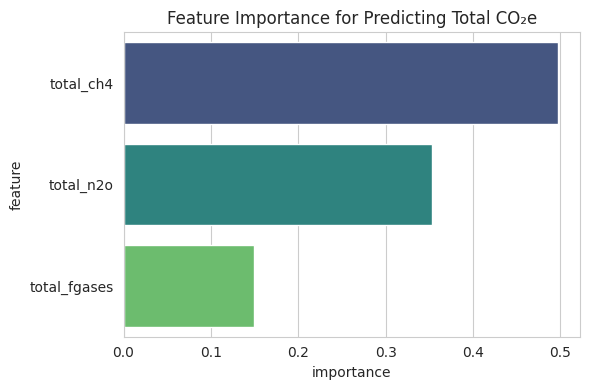

In [32]:
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances}) \
            .sort_values('importance', ascending=False)

print(feat_imp)

plt.figure(figsize=(6,4))
sns.barplot(data=feat_imp, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Predicting Total CO₂e')
plt.tight_layout()
plt.show()

## Actual vs. predicted plot

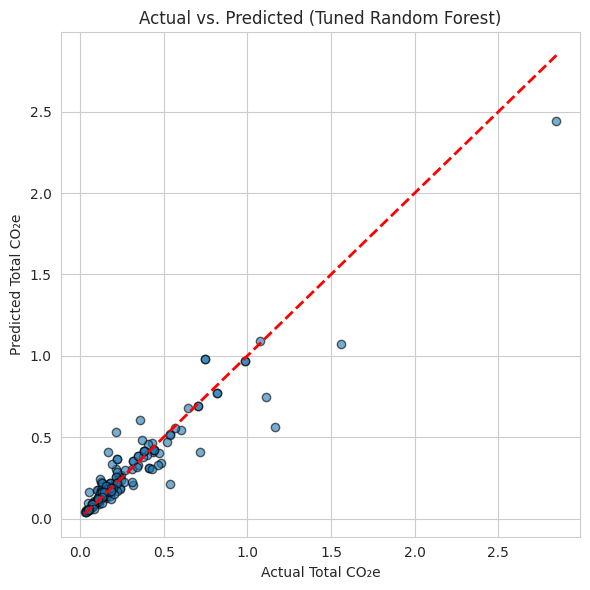

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total CO₂e')
plt.ylabel('Predicted Total CO₂e')
plt.title('Actual vs. Predicted (Tuned Random Forest)')
plt.tight_layout()
plt.show()

## Residual analysis

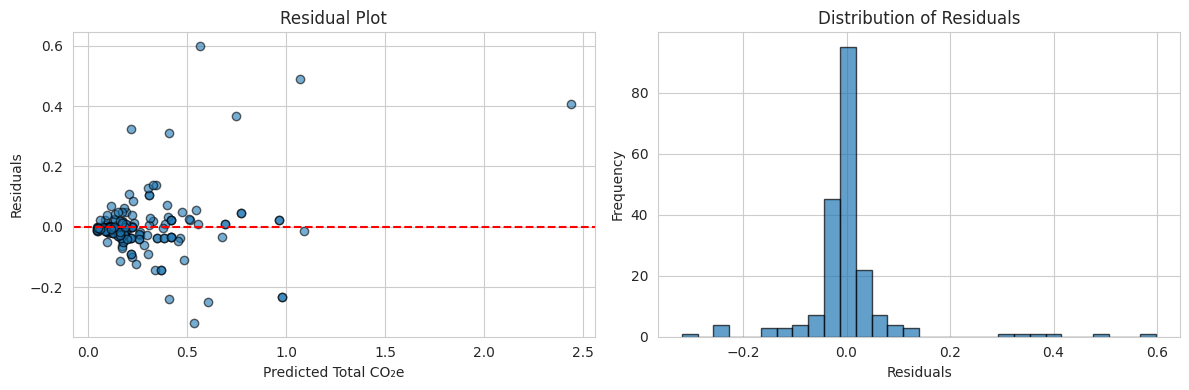

In [34]:
residuals = y_test - y_pred_tuned

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(y_pred_tuned, residuals, alpha=0.6, edgecolors='k')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Total CO₂e')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')

axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

#**Research Question 4: Unsupervised Carbon Risk Clustering**

In [35]:
"""
Research Question 4: Unsupervised Carbon Risk Clustering

"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# Define GWP values (CO2e = kg_gas * GWP)
gwp = {
    'Carbon dioxide': 1,
    'Methane': 28,
    'Nitrous oxide': 265,
    'HFCs and PFCs, unspecified': 1      # already in CO2e
}

# Filter to the gases we will use
gas_list = list(gwp.keys())
df_filtered = df_GHG[df_GHG['GHG'].isin(gas_list)].copy()

# Convert to CO2e
df_filtered['sef_co2e'] = df_filtered['Supply Chain Emission Factors without Margins'] * df_filtered['GHG'].map(gwp)
df_filtered['mef_co2e'] = df_filtered['Margins of Supply Chain Emission Factors'] * df_filtered['GHG'].map(gwp)

# Aggregate per NAICS code
cluster_df = df_filtered.groupby('2017 NAICS Code').agg({
    'sef_co2e': 'sum',
    'mef_co2e': 'sum'
}).reset_index()

# Keep NAICS title for interpretation (first occurrence)
titles = df_filtered.groupby('2017 NAICS Code')['2017 NAICS Title'].first()
cluster_df = cluster_df.merge(titles, on='2017 NAICS Code', how='left')

# Inspect the aggregated data
print("Aggregated data shape:", cluster_df.shape)
cluster_df.head()

Aggregated data shape: (1016, 4)


,2017 NAICS Code,sef_co2e,mef_co2e,2017 NAICS Title
0,111110,0.488126,0.043563,Soybean Farming
1,111120,0.488126,0.043563,Oilseed (except Soybean) Farming
2,111130,0.808254,0.039254,Dry Pea and Bean Farming
3,111140,0.808254,0.039254,Wheat Farming
4,111150,0.808254,0.039254,Corn Farming


## Data Scaling and Exploration

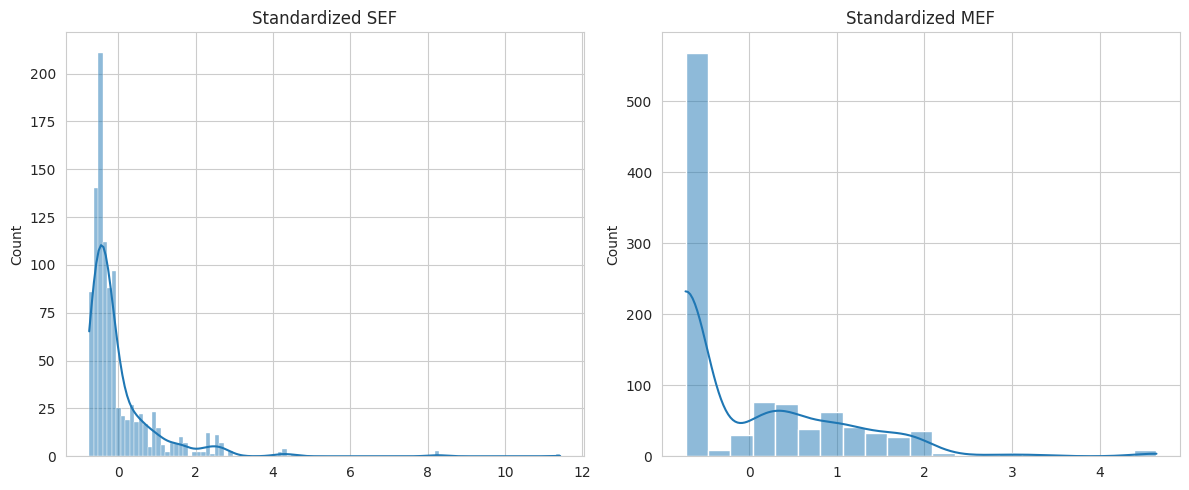

In [36]:
# ------------------------------------------------------------
# 2. Standardize the features
# ------------------------------------------------------------
features = cluster_df[['sef_co2e', 'mef_co2e']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Quick check of distributions after scaling
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(features_scaled[:,0], kde=True).set_title('Standardized SEF')
plt.subplot(1,2,2)
sns.histplot(features_scaled[:,1], kde=True).set_title('Standardized MEF')
plt.tight_layout()
plt.show()

## Determining the Optimal Number of Clusters

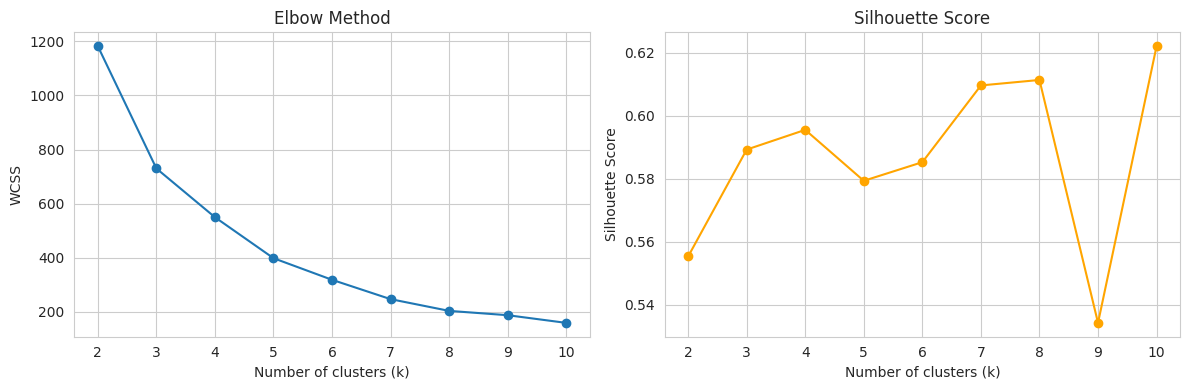

In [37]:
# ------------------------------------------------------------
# 3. Find optimal k using elbow and silhouette
# ------------------------------------------------------------
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, labels))

# Plot both metrics
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(K_range, wcss, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('WCSS')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## K‑Means Clustering with k = 4

In [38]:
# ------------------------------------------------------------
# 4. Apply K-Means with k = 4
# ------------------------------------------------------------
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original dataframe
cluster_df['Cluster'] = cluster_labels

# Examine cluster centers (in original scale for interpretation)
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original,
                          columns=['SEF_center', 'MEF_center'])
centers_df['Cluster'] = range(4)
print("Cluster centers (original units – kg CO₂e / USD):")
centers_df

Cluster centers (original units – kg CO₂e / USD):


,SEF_center,MEF_center,Cluster
0,0.261744,0.044894,0
1,0.155889,0.002820,1
2,3.096957,0.052947,2
3,0.954583,0.024081,3


## Visualising the Clusters

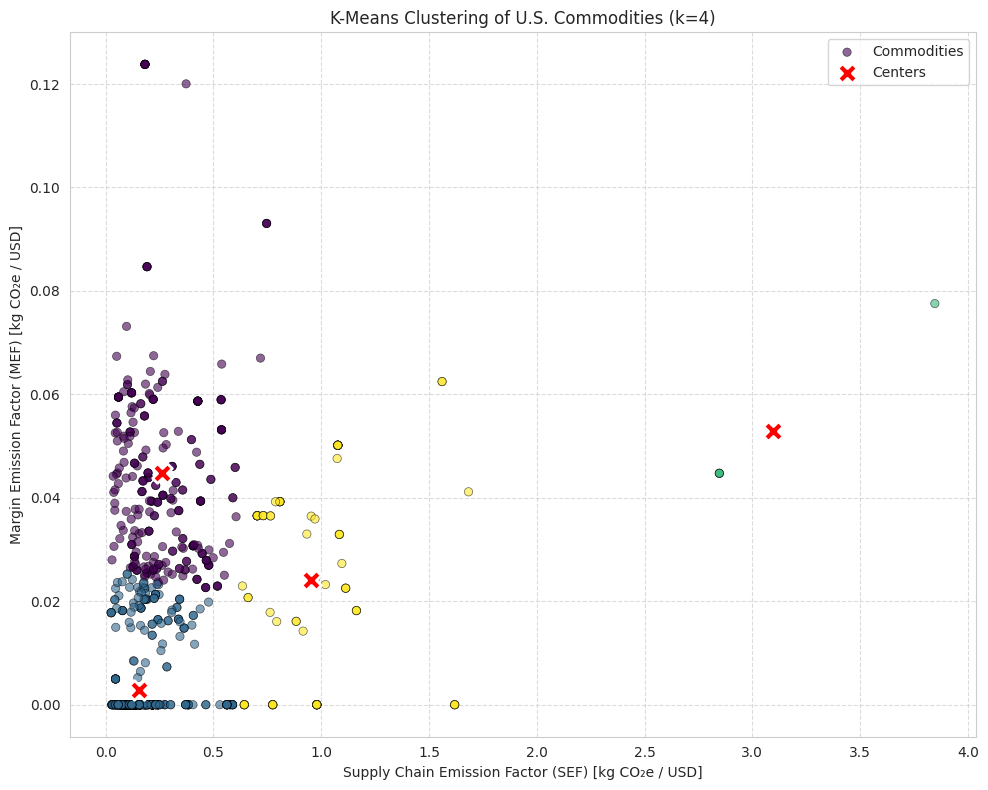

In [39]:
# ------------------------------------------------------------
# 5. Visualize clusters
# ------------------------------------------------------------
plt.figure(figsize=(10,8))
scatter = plt.scatter(cluster_df['sef_co2e'],
                      cluster_df['mef_co2e'],
                      c=cluster_df['Cluster'],
                      cmap='viridis',
                      alpha=0.6,
                      edgecolors='k',
                      linewidth=0.5)
plt.xlabel('Supply Chain Emission Factor (SEF) [kg CO₂e / USD]')
plt.ylabel('Margin Emission Factor (MEF) [kg CO₂e / USD]')
plt.title('K-Means Clustering of U.S. Commodities (k=4)')

# Mark cluster centers
centers = plt.scatter(centers_original[:,0],
                      centers_original[:,1],
                      marker='X',
                      s=200,
                      c='red',
                      edgecolors='white',
                      linewidth=2,
                      label='Cluster Centers')
plt.legend(handles=[scatter, centers], labels=['Commodities', 'Centers'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Profiling the Clusters

In [40]:
# ------------------------------------------------------------
# 6. Profile clusters – show top industries per cluster
# ------------------------------------------------------------
for cl in range(4):
    print(f"\n--- Cluster {cl} ---")
    print(cluster_df[cluster_df['Cluster'] == cl][['2017 NAICS Title', 'sef_co2e', 'mef_co2e']].head(10).to_string(index=False))


--- Cluster 0 ---
                                 2017 NAICS Title  sef_co2e  mef_co2e
                                  Soybean Farming  0.488126  0.043563
                 Oilseed (except Soybean) Farming  0.488126  0.043563
                                   Potato Farming  0.589968  0.040012
Other Vegetable (except Potato) and Melon Farming  0.589968  0.040012
                                    Orange Groves  0.427538  0.058691
                    Citrus (except Orange) Groves  0.427538  0.058691
                                   Apple Orchards  0.427538  0.058691
                                  Grape Vineyards  0.427538  0.058691
                               Strawberry Farming  0.427538  0.058691
                Berry (except Strawberry) Farming  0.427538  0.058691

--- Cluster 1 ---
                                   2017 NAICS Title  sef_co2e  mef_co2e
                                     Cotton Ginning  0.383243       0.0
        Soil Preparation, Planting, and Cultivat